# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

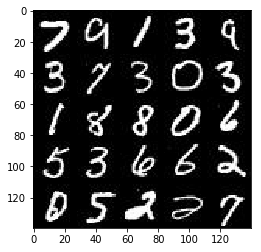

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

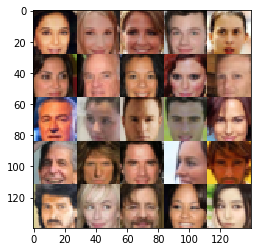

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.layers.conv2d(inputs=images, filters=64, kernel_size=5, strides=2, padding='same')
        x = tf.maximum(alpha * x, x)
        
        def conv_layer(inputs, filters, kernel_size=5, strides=2, padding='same'):
            conv_layer = tf.layers.conv2d(inputs=inputs, filters=filters, kernel_size=kernel_size,
                                          strides=strides, padding=padding)
            conv_layer = tf.layers.batch_normalization(inputs=conv_layer, training=True)
            conv_layer = tf.maximum(alpha * conv_layer, conv_layer)
            conv_layer = tf.nn.dropout(x=conv_layer, keep_prob=0.50)
            return conv_layer
        
        conv_layer1 = conv_layer(inputs=x, filters=128)
        conv_layer2 = conv_layer(inputs=conv_layer1, filters=256)
        conv_layer3 = conv_layer(inputs=conv_layer2, filters=512)
        conv_layer3_volume = conv_layer3.get_shape().as_list()[1] * conv_layer3.get_shape().as_list()[2] * conv_layer3.get_shape().as_list()[3]
        conv_layer3_flattened = tf.reshape(conv_layer3, [-1, conv_layer3_volume])
        logits = tf.layers.dense(inputs=conv_layer3_flattened, units=1)
        out = tf.sigmoid(x=logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x = tf.layers.dense(inputs=z, units=7*7*1024)
        x = tf.reshape(x, shape=[-1, 7, 7, 1024])
        x = tf.layers.batch_normalization(inputs=x, training=is_train)
        x = tf.maximum(alpha * x, x)

        def conv2d_transpose(inputs, filters, kernel_size=5, strides=2, padding='same', normalize=True):
            conv_layer_transpose = tf.layers.conv2d_transpose(inputs=inputs, filters=filters, kernel_size=kernel_size,
                                                              strides=strides, padding=padding)
            if normalize:
                conv_layer_transpose = tf.layers.batch_normalization(inputs=conv_layer_transpose, training=is_train)
            conv_layer_transpose = tf.maximum(alpha * conv_layer_transpose, conv_layer_transpose)
            
            return conv_layer_transpose

        conv_layer_transpose1 = conv2d_transpose(inputs=x, filters=512)
        conv_layer_transpose2 = conv2d_transpose(inputs=conv_layer_transpose1, filters=256)
        conv_layer_transpose3 = conv2d_transpose(inputs=conv_layer_transpose2, filters=128, strides=(1, 1))

        logits = conv2d_transpose(inputs=conv_layer_transpose3, filters=out_channel_dim, strides=(1, 1), 
                                  normalize=False)
        out = tf.tanh(x=logits) * 0.50
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(z=input_z, out_channel_dim=out_channel_dim)
    d_model_real, d_logits_real = discriminator(images=input_real)
    d_model_fake, d_logits_fake = discriminator(images=g_model, reuse=True)
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                             labels=tf.ones_like(d_model_fake)))
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                             labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                             labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    trainable_vars = tf.trainable_variables()
    d_vars = [var for var in trainable_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in trainable_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_op = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_op = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_op, g_train_op


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width = data_shape[1]
    image_height = data_shape[2]
    out_channel_dim = data_shape[3]
    input_real, input_z, learning_rate_p = model_inputs(image_width=image_width, image_height=image_height, 
                                                      image_channels=out_channel_dim, z_dim=z_dim)
    d_loss, g_loss = model_loss(input_real=input_real, input_z=input_z, out_channel_dim=out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss=d_loss, g_loss=g_loss, learning_rate=learning_rate, beta1=beta1) 
    
    step = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                
                batch_z = np.random.uniform(-0.5, 0.5, size=[batch_size, z_dim])
                
                _ = sess.run(d_train_opt, 
                             feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_p: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, 
                                                     learning_rate_p: learning_rate})
                
                train_loss_d = sess.run(d_loss, feed_dict={input_real: batch_images, input_z: batch_z})
                train_loss_g = sess.run(g_loss, feed_dict={input_z: batch_z})
            
                print("Epoch {}/{}".format(epoch_i + 1, epoch_count),
                      "Discriminator loss: {:.4f}".format(train_loss_d),
                      "Generator loss: {:.4f}".format(train_loss_g))
                if step == 1 or step % 20 == 0:
                    show_generator_output(sess=sess, n_images=25, input_z=input_z, 
                                      out_channel_dim=out_channel_dim, image_mode=data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Discriminator loss: 1.2381 Generator loss: 0.6691


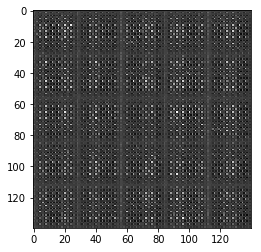

Epoch 1/2 Discriminator loss: 0.2492 Generator loss: 3.1882
Epoch 1/2 Discriminator loss: 0.0661 Generator loss: 5.1176
Epoch 1/2 Discriminator loss: 0.0645 Generator loss: 4.0276
Epoch 1/2 Discriminator loss: 0.0286 Generator loss: 5.0836
Epoch 1/2 Discriminator loss: 0.0108 Generator loss: 6.5405
Epoch 1/2 Discriminator loss: 0.0053 Generator loss: 6.8311
Epoch 1/2 Discriminator loss: 0.0440 Generator loss: 4.1918
Epoch 1/2 Discriminator loss: 0.0444 Generator loss: 4.4503
Epoch 1/2 Discriminator loss: 0.0152 Generator loss: 5.8177
Epoch 1/2 Discriminator loss: 0.0197 Generator loss: 5.9252
Epoch 1/2 Discriminator loss: 0.0301 Generator loss: 5.3568
Epoch 1/2 Discriminator loss: 0.0274 Generator loss: 5.0763
Epoch 1/2 Discriminator loss: 0.0998 Generator loss: 3.8760
Epoch 1/2 Discriminator loss: 0.0506 Generator loss: 7.7917
Epoch 1/2 Discriminator loss: 0.0736 Generator loss: 5.5667
Epoch 1/2 Discriminator loss: 0.1548 Generator loss: 3.2486
Epoch 1/2 Discriminator loss: 0.1977 Gen

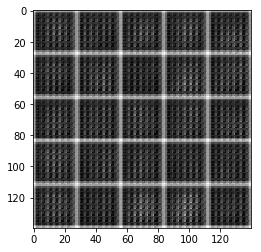

Epoch 1/2 Discriminator loss: 1.5131 Generator loss: 16.4468
Epoch 1/2 Discriminator loss: 0.1269 Generator loss: 8.8374
Epoch 1/2 Discriminator loss: 4.0892 Generator loss: 0.9236
Epoch 1/2 Discriminator loss: 0.1595 Generator loss: 5.4472
Epoch 1/2 Discriminator loss: 1.6724 Generator loss: 2.9059
Epoch 1/2 Discriminator loss: 1.9217 Generator loss: 0.4889
Epoch 1/2 Discriminator loss: 1.8016 Generator loss: 10.5750
Epoch 1/2 Discriminator loss: 0.5429 Generator loss: 2.3942
Epoch 1/2 Discriminator loss: 2.3604 Generator loss: 2.2385
Epoch 1/2 Discriminator loss: 0.8042 Generator loss: 6.0856
Epoch 1/2 Discriminator loss: 1.3968 Generator loss: 2.6482
Epoch 1/2 Discriminator loss: 1.5982 Generator loss: 2.2070
Epoch 1/2 Discriminator loss: 1.5092 Generator loss: 1.7378
Epoch 1/2 Discriminator loss: 0.8052 Generator loss: 2.9875
Epoch 1/2 Discriminator loss: 0.5400 Generator loss: 2.1810
Epoch 1/2 Discriminator loss: 0.4807 Generator loss: 2.5932
Epoch 1/2 Discriminator loss: 0.6519 G

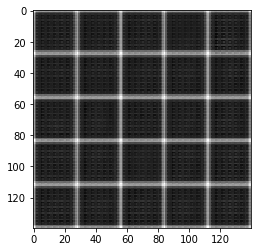

Epoch 1/2 Discriminator loss: 2.0246 Generator loss: 0.5189
Epoch 1/2 Discriminator loss: 2.2147 Generator loss: 5.0791
Epoch 1/2 Discriminator loss: 3.0459 Generator loss: 0.2058
Epoch 1/2 Discriminator loss: 2.2342 Generator loss: 5.8493
Epoch 1/2 Discriminator loss: 1.0123 Generator loss: 2.3763
Epoch 1/2 Discriminator loss: 1.4389 Generator loss: 1.6461
Epoch 1/2 Discriminator loss: 1.2277 Generator loss: 4.4066
Epoch 1/2 Discriminator loss: 2.4671 Generator loss: 0.4705
Epoch 1/2 Discriminator loss: 2.3177 Generator loss: 2.1541
Epoch 1/2 Discriminator loss: 1.4624 Generator loss: 0.9856
Epoch 1/2 Discriminator loss: 3.1602 Generator loss: 0.2068
Epoch 1/2 Discriminator loss: 2.3706 Generator loss: 8.1830
Epoch 1/2 Discriminator loss: 0.5193 Generator loss: 4.7862
Epoch 1/2 Discriminator loss: 2.1419 Generator loss: 0.4233
Epoch 1/2 Discriminator loss: 1.3492 Generator loss: 1.2947
Epoch 1/2 Discriminator loss: 3.0735 Generator loss: 0.5674
Epoch 1/2 Discriminator loss: 2.8521 Gen

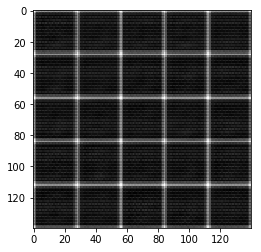

Epoch 1/2 Discriminator loss: 1.5830 Generator loss: 2.4182
Epoch 1/2 Discriminator loss: 0.8396 Generator loss: 1.3273
Epoch 1/2 Discriminator loss: 0.8190 Generator loss: 1.3856
Epoch 1/2 Discriminator loss: 1.3070 Generator loss: 0.9180
Epoch 1/2 Discriminator loss: 1.4863 Generator loss: 1.2462
Epoch 1/2 Discriminator loss: 2.0782 Generator loss: 0.7163
Epoch 1/2 Discriminator loss: 2.3383 Generator loss: 0.5497
Epoch 1/2 Discriminator loss: 2.1272 Generator loss: 1.0293
Epoch 1/2 Discriminator loss: 1.5756 Generator loss: 1.2953
Epoch 1/2 Discriminator loss: 1.0672 Generator loss: 1.1706
Epoch 1/2 Discriminator loss: 1.0290 Generator loss: 1.3580
Epoch 1/2 Discriminator loss: 0.9603 Generator loss: 1.6913
Epoch 1/2 Discriminator loss: 0.9493 Generator loss: 1.9463
Epoch 1/2 Discriminator loss: 0.8733 Generator loss: 1.5617
Epoch 1/2 Discriminator loss: 1.1289 Generator loss: 1.1477
Epoch 1/2 Discriminator loss: 1.1127 Generator loss: 1.5715
Epoch 1/2 Discriminator loss: 1.2803 Gen

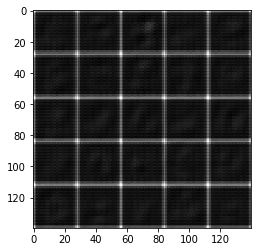

Epoch 1/2 Discriminator loss: 1.7417 Generator loss: 1.4343
Epoch 1/2 Discriminator loss: 1.7298 Generator loss: 0.7891
Epoch 1/2 Discriminator loss: 1.3896 Generator loss: 1.0237
Epoch 1/2 Discriminator loss: 1.2844 Generator loss: 1.4120
Epoch 1/2 Discriminator loss: 1.1839 Generator loss: 1.1181
Epoch 1/2 Discriminator loss: 0.9225 Generator loss: 1.0853
Epoch 1/2 Discriminator loss: 1.1083 Generator loss: 1.4313
Epoch 1/2 Discriminator loss: 1.3122 Generator loss: 1.0522
Epoch 1/2 Discriminator loss: 1.4596 Generator loss: 1.0183
Epoch 1/2 Discriminator loss: 1.6910 Generator loss: 0.9127
Epoch 1/2 Discriminator loss: 1.9352 Generator loss: 0.5822
Epoch 1/2 Discriminator loss: 1.6599 Generator loss: 0.9306
Epoch 1/2 Discriminator loss: 1.4136 Generator loss: 1.1117
Epoch 1/2 Discriminator loss: 1.2210 Generator loss: 1.0785
Epoch 1/2 Discriminator loss: 1.1855 Generator loss: 1.1589
Epoch 1/2 Discriminator loss: 1.0622 Generator loss: 1.4053
Epoch 1/2 Discriminator loss: 1.2091 Gen

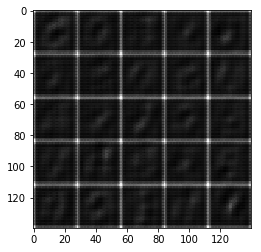

Epoch 1/2 Discriminator loss: 1.4595 Generator loss: 0.8326
Epoch 1/2 Discriminator loss: 1.1280 Generator loss: 1.3149
Epoch 1/2 Discriminator loss: 1.3063 Generator loss: 0.8493
Epoch 1/2 Discriminator loss: 1.3208 Generator loss: 0.9522
Epoch 1/2 Discriminator loss: 1.3501 Generator loss: 1.1809
Epoch 1/2 Discriminator loss: 1.7081 Generator loss: 0.5937
Epoch 1/2 Discriminator loss: 1.6197 Generator loss: 1.0076
Epoch 1/2 Discriminator loss: 1.5133 Generator loss: 0.8211
Epoch 1/2 Discriminator loss: 1.1820 Generator loss: 1.7606
Epoch 1/2 Discriminator loss: 1.0942 Generator loss: 0.9895
Epoch 1/2 Discriminator loss: 0.9109 Generator loss: 1.4454
Epoch 1/2 Discriminator loss: 1.1610 Generator loss: 1.1056
Epoch 1/2 Discriminator loss: 1.6195 Generator loss: 0.6451
Epoch 1/2 Discriminator loss: 2.0098 Generator loss: 0.8382
Epoch 1/2 Discriminator loss: 1.7901 Generator loss: 0.5377
Epoch 1/2 Discriminator loss: 1.4218 Generator loss: 1.3532
Epoch 1/2 Discriminator loss: 1.6505 Gen

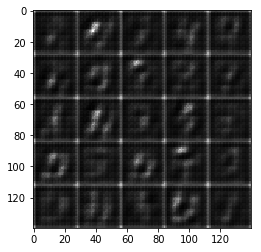

Epoch 1/2 Discriminator loss: 1.6114 Generator loss: 1.4818
Epoch 1/2 Discriminator loss: 1.7663 Generator loss: 0.5850
Epoch 1/2 Discriminator loss: 1.6108 Generator loss: 1.2980
Epoch 1/2 Discriminator loss: 1.3391 Generator loss: 0.6566
Epoch 1/2 Discriminator loss: 1.2086 Generator loss: 1.2022
Epoch 1/2 Discriminator loss: 1.2790 Generator loss: 0.7589
Epoch 1/2 Discriminator loss: 1.3082 Generator loss: 1.1262
Epoch 1/2 Discriminator loss: 1.4288 Generator loss: 0.9839
Epoch 1/2 Discriminator loss: 1.3517 Generator loss: 1.0240
Epoch 1/2 Discriminator loss: 1.4186 Generator loss: 1.2419
Epoch 1/2 Discriminator loss: 1.2307 Generator loss: 0.9995
Epoch 1/2 Discriminator loss: 1.2529 Generator loss: 1.0796
Epoch 1/2 Discriminator loss: 1.2301 Generator loss: 1.0574
Epoch 1/2 Discriminator loss: 1.7384 Generator loss: 0.6881
Epoch 1/2 Discriminator loss: 2.0104 Generator loss: 0.8236
Epoch 1/2 Discriminator loss: 1.6319 Generator loss: 0.9786
Epoch 1/2 Discriminator loss: 1.4991 Gen

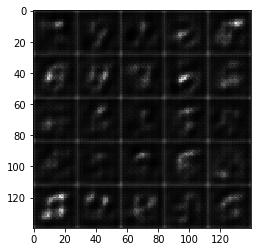

Epoch 1/2 Discriminator loss: 1.5959 Generator loss: 0.8019
Epoch 1/2 Discriminator loss: 1.4225 Generator loss: 0.9027
Epoch 1/2 Discriminator loss: 1.5350 Generator loss: 0.7002
Epoch 1/2 Discriminator loss: 1.6254 Generator loss: 0.8284
Epoch 1/2 Discriminator loss: 1.3775 Generator loss: 0.8257
Epoch 1/2 Discriminator loss: 1.4931 Generator loss: 1.1008
Epoch 1/2 Discriminator loss: 1.1051 Generator loss: 1.0400
Epoch 1/2 Discriminator loss: 1.3005 Generator loss: 0.9340
Epoch 1/2 Discriminator loss: 1.0911 Generator loss: 1.0901
Epoch 1/2 Discriminator loss: 1.2731 Generator loss: 1.0384
Epoch 1/2 Discriminator loss: 1.6505 Generator loss: 0.8545
Epoch 1/2 Discriminator loss: 1.7372 Generator loss: 0.6294
Epoch 1/2 Discriminator loss: 1.4518 Generator loss: 0.9216
Epoch 1/2 Discriminator loss: 1.3230 Generator loss: 1.0553
Epoch 1/2 Discriminator loss: 1.2141 Generator loss: 0.9356
Epoch 1/2 Discriminator loss: 1.1801 Generator loss: 1.0056
Epoch 1/2 Discriminator loss: 1.2636 Gen

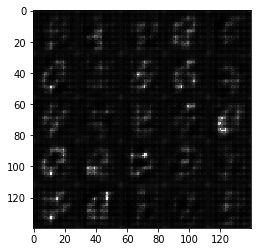

Epoch 1/2 Discriminator loss: 1.5532 Generator loss: 0.5725
Epoch 1/2 Discriminator loss: 1.3513 Generator loss: 1.3512
Epoch 1/2 Discriminator loss: 1.7545 Generator loss: 0.5038
Epoch 1/2 Discriminator loss: 1.5252 Generator loss: 0.7610
Epoch 1/2 Discriminator loss: 1.6478 Generator loss: 0.8065
Epoch 1/2 Discriminator loss: 1.5797 Generator loss: 0.6522
Epoch 1/2 Discriminator loss: 1.3811 Generator loss: 0.9620
Epoch 1/2 Discriminator loss: 1.1770 Generator loss: 1.0616
Epoch 1/2 Discriminator loss: 1.2485 Generator loss: 0.8211
Epoch 1/2 Discriminator loss: 1.0700 Generator loss: 1.0943
Epoch 1/2 Discriminator loss: 1.1467 Generator loss: 0.7832
Epoch 1/2 Discriminator loss: 1.4438 Generator loss: 0.9891
Epoch 1/2 Discriminator loss: 1.5595 Generator loss: 0.7487
Epoch 1/2 Discriminator loss: 1.6657 Generator loss: 0.6885
Epoch 1/2 Discriminator loss: 1.5244 Generator loss: 0.7952
Epoch 1/2 Discriminator loss: 1.2377 Generator loss: 1.3452
Epoch 1/2 Discriminator loss: 1.2003 Gen

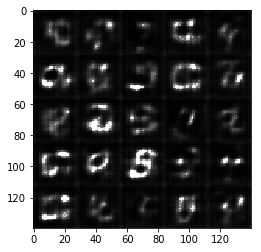

Epoch 1/2 Discriminator loss: 1.5368 Generator loss: 0.9651
Epoch 1/2 Discriminator loss: 1.8028 Generator loss: 0.5352
Epoch 1/2 Discriminator loss: 1.8923 Generator loss: 0.6435
Epoch 1/2 Discriminator loss: 1.9421 Generator loss: 0.6350
Epoch 1/2 Discriminator loss: 1.5861 Generator loss: 0.9098
Epoch 1/2 Discriminator loss: 1.3424 Generator loss: 0.6887
Epoch 1/2 Discriminator loss: 1.1282 Generator loss: 1.0547
Epoch 1/2 Discriminator loss: 1.2234 Generator loss: 1.2435
Epoch 1/2 Discriminator loss: 1.4138 Generator loss: 0.6508
Epoch 1/2 Discriminator loss: 1.4121 Generator loss: 1.1834
Epoch 1/2 Discriminator loss: 1.4992 Generator loss: 0.8421
Epoch 1/2 Discriminator loss: 1.4673 Generator loss: 0.6113
Epoch 1/2 Discriminator loss: 1.5163 Generator loss: 1.1743
Epoch 1/2 Discriminator loss: 1.6291 Generator loss: 0.5435
Epoch 1/2 Discriminator loss: 1.6184 Generator loss: 0.7682
Epoch 1/2 Discriminator loss: 1.4091 Generator loss: 0.8892
Epoch 1/2 Discriminator loss: 1.2196 Gen

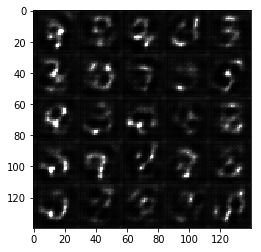

Epoch 1/2 Discriminator loss: 1.2799 Generator loss: 1.0139
Epoch 1/2 Discriminator loss: 1.5037 Generator loss: 0.8573
Epoch 1/2 Discriminator loss: 1.4269 Generator loss: 0.8315
Epoch 1/2 Discriminator loss: 1.6008 Generator loss: 0.7939
Epoch 1/2 Discriminator loss: 1.6292 Generator loss: 0.6774
Epoch 1/2 Discriminator loss: 1.6491 Generator loss: 0.7948
Epoch 1/2 Discriminator loss: 1.4266 Generator loss: 0.7479
Epoch 1/2 Discriminator loss: 1.2836 Generator loss: 0.9245
Epoch 1/2 Discriminator loss: 1.1553 Generator loss: 1.0641
Epoch 1/2 Discriminator loss: 1.2177 Generator loss: 0.7586
Epoch 1/2 Discriminator loss: 1.2847 Generator loss: 1.0120
Epoch 1/2 Discriminator loss: 1.3677 Generator loss: 0.9957
Epoch 1/2 Discriminator loss: 1.3744 Generator loss: 1.0029
Epoch 1/2 Discriminator loss: 1.4879 Generator loss: 0.8269
Epoch 1/2 Discriminator loss: 1.4144 Generator loss: 0.7553
Epoch 1/2 Discriminator loss: 1.3534 Generator loss: 1.0635
Epoch 1/2 Discriminator loss: 1.3801 Gen

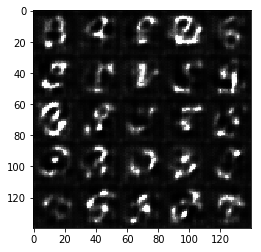

Epoch 1/2 Discriminator loss: 1.4151 Generator loss: 0.7777
Epoch 1/2 Discriminator loss: 1.3855 Generator loss: 1.0357
Epoch 1/2 Discriminator loss: 1.1961 Generator loss: 1.0754
Epoch 1/2 Discriminator loss: 1.3995 Generator loss: 0.6677
Epoch 1/2 Discriminator loss: 1.1536 Generator loss: 1.1717
Epoch 1/2 Discriminator loss: 1.2014 Generator loss: 0.9128
Epoch 1/2 Discriminator loss: 1.4187 Generator loss: 0.7808
Epoch 1/2 Discriminator loss: 1.4535 Generator loss: 0.8770
Epoch 1/2 Discriminator loss: 1.4105 Generator loss: 0.9723
Epoch 1/2 Discriminator loss: 1.5213 Generator loss: 0.8096
Epoch 1/2 Discriminator loss: 1.3998 Generator loss: 1.0737
Epoch 1/2 Discriminator loss: 1.4121 Generator loss: 0.7763
Epoch 1/2 Discriminator loss: 1.2642 Generator loss: 0.9067
Epoch 1/2 Discriminator loss: 1.3462 Generator loss: 0.8458
Epoch 1/2 Discriminator loss: 1.4625 Generator loss: 0.6003
Epoch 1/2 Discriminator loss: 1.5185 Generator loss: 0.8722
Epoch 1/2 Discriminator loss: 1.5515 Gen

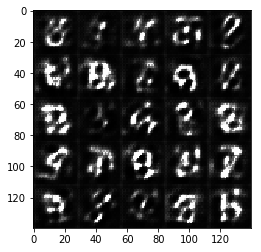

Epoch 1/2 Discriminator loss: 1.5594 Generator loss: 0.9588
Epoch 1/2 Discriminator loss: 1.4007 Generator loss: 0.8864
Epoch 1/2 Discriminator loss: 1.2253 Generator loss: 1.1034
Epoch 1/2 Discriminator loss: 1.2476 Generator loss: 0.8615
Epoch 1/2 Discriminator loss: 1.5801 Generator loss: 0.5335
Epoch 1/2 Discriminator loss: 1.2543 Generator loss: 1.2515
Epoch 1/2 Discriminator loss: 1.5531 Generator loss: 0.7167
Epoch 1/2 Discriminator loss: 1.6095 Generator loss: 0.8300
Epoch 1/2 Discriminator loss: 1.6543 Generator loss: 0.5337
Epoch 1/2 Discriminator loss: 1.7233 Generator loss: 1.0358
Epoch 1/2 Discriminator loss: 1.3965 Generator loss: 0.6675
Epoch 1/2 Discriminator loss: 1.3430 Generator loss: 1.0618
Epoch 1/2 Discriminator loss: 1.0472 Generator loss: 1.0399
Epoch 1/2 Discriminator loss: 1.1665 Generator loss: 0.8085
Epoch 1/2 Discriminator loss: 1.1764 Generator loss: 0.9437
Epoch 1/2 Discriminator loss: 1.4387 Generator loss: 0.7522
Epoch 1/2 Discriminator loss: 1.3484 Gen

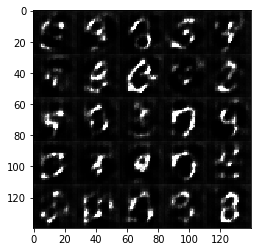

Epoch 1/2 Discriminator loss: 1.5378 Generator loss: 0.5995
Epoch 1/2 Discriminator loss: 1.3461 Generator loss: 0.9060
Epoch 1/2 Discriminator loss: 1.3656 Generator loss: 0.9018
Epoch 1/2 Discriminator loss: 1.4412 Generator loss: 0.7620
Epoch 1/2 Discriminator loss: 1.3260 Generator loss: 1.1805
Epoch 1/2 Discriminator loss: 1.5031 Generator loss: 0.6961
Epoch 1/2 Discriminator loss: 1.3734 Generator loss: 0.5535
Epoch 1/2 Discriminator loss: 1.5743 Generator loss: 1.1477
Epoch 1/2 Discriminator loss: 1.9302 Generator loss: 0.4515
Epoch 1/2 Discriminator loss: 1.6491 Generator loss: 0.7596
Epoch 1/2 Discriminator loss: 1.6956 Generator loss: 0.6155
Epoch 1/2 Discriminator loss: 1.2912 Generator loss: 0.8758
Epoch 1/2 Discriminator loss: 1.4678 Generator loss: 0.7842
Epoch 1/2 Discriminator loss: 1.5564 Generator loss: 0.5927
Epoch 1/2 Discriminator loss: 1.7018 Generator loss: 0.9641
Epoch 1/2 Discriminator loss: 1.6175 Generator loss: 0.6550
Epoch 1/2 Discriminator loss: 1.8318 Gen

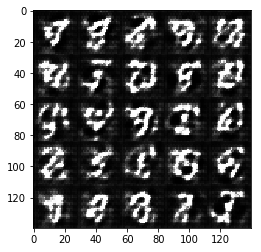

Epoch 1/2 Discriminator loss: 1.3312 Generator loss: 0.9274
Epoch 1/2 Discriminator loss: 1.3154 Generator loss: 1.0667
Epoch 1/2 Discriminator loss: 1.4016 Generator loss: 0.6692
Epoch 1/2 Discriminator loss: 1.6167 Generator loss: 0.7637
Epoch 1/2 Discriminator loss: 1.3784 Generator loss: 0.7323
Epoch 1/2 Discriminator loss: 1.4678 Generator loss: 0.6509
Epoch 1/2 Discriminator loss: 1.3439 Generator loss: 0.9314
Epoch 1/2 Discriminator loss: 1.2582 Generator loss: 0.8648
Epoch 1/2 Discriminator loss: 1.2842 Generator loss: 1.1196
Epoch 1/2 Discriminator loss: 1.0464 Generator loss: 0.8213
Epoch 1/2 Discriminator loss: 0.9465 Generator loss: 1.1398
Epoch 1/2 Discriminator loss: 1.1990 Generator loss: 1.0648
Epoch 1/2 Discriminator loss: 1.4799 Generator loss: 0.6177
Epoch 1/2 Discriminator loss: 1.4529 Generator loss: 0.8151
Epoch 1/2 Discriminator loss: 1.6012 Generator loss: 0.6957
Epoch 1/2 Discriminator loss: 1.7247 Generator loss: 0.4774
Epoch 1/2 Discriminator loss: 1.7012 Gen

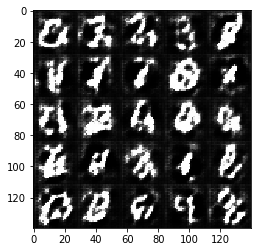

Epoch 1/2 Discriminator loss: 1.3914 Generator loss: 1.0822
Epoch 1/2 Discriminator loss: 1.2828 Generator loss: 0.9177
Epoch 1/2 Discriminator loss: 1.2286 Generator loss: 0.7582
Epoch 1/2 Discriminator loss: 1.3264 Generator loss: 0.9891
Epoch 1/2 Discriminator loss: 1.4078 Generator loss: 0.7064
Epoch 1/2 Discriminator loss: 1.3581 Generator loss: 0.7294
Epoch 1/2 Discriminator loss: 1.5801 Generator loss: 0.8632
Epoch 1/2 Discriminator loss: 1.4929 Generator loss: 0.5848
Epoch 1/2 Discriminator loss: 1.5956 Generator loss: 0.7858
Epoch 1/2 Discriminator loss: 1.3235 Generator loss: 0.9247
Epoch 1/2 Discriminator loss: 1.0808 Generator loss: 1.0133
Epoch 1/2 Discriminator loss: 0.9670 Generator loss: 1.0356
Epoch 1/2 Discriminator loss: 1.0844 Generator loss: 1.0697
Epoch 1/2 Discriminator loss: 1.1116 Generator loss: 0.9171
Epoch 1/2 Discriminator loss: 1.3126 Generator loss: 0.7645
Epoch 1/2 Discriminator loss: 1.3074 Generator loss: 1.2384
Epoch 1/2 Discriminator loss: 1.5613 Gen

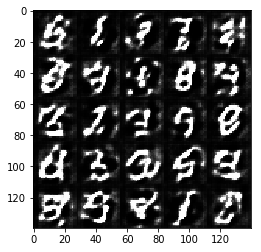

Epoch 1/2 Discriminator loss: 1.3918 Generator loss: 1.2555
Epoch 1/2 Discriminator loss: 1.2241 Generator loss: 0.4771
Epoch 1/2 Discriminator loss: 1.1806 Generator loss: 1.1437
Epoch 1/2 Discriminator loss: 1.4632 Generator loss: 0.8211
Epoch 1/2 Discriminator loss: 1.4436 Generator loss: 0.6772
Epoch 1/2 Discriminator loss: 1.6321 Generator loss: 0.8666
Epoch 1/2 Discriminator loss: 1.8186 Generator loss: 0.5385
Epoch 1/2 Discriminator loss: 1.7031 Generator loss: 0.6483
Epoch 1/2 Discriminator loss: 1.3992 Generator loss: 0.9291
Epoch 1/2 Discriminator loss: 1.3636 Generator loss: 0.8363
Epoch 1/2 Discriminator loss: 1.1138 Generator loss: 0.9240
Epoch 1/2 Discriminator loss: 1.0376 Generator loss: 1.1079
Epoch 1/2 Discriminator loss: 0.9418 Generator loss: 1.0929
Epoch 1/2 Discriminator loss: 1.1657 Generator loss: 1.0101
Epoch 1/2 Discriminator loss: 1.2273 Generator loss: 0.8188
Epoch 1/2 Discriminator loss: 1.4502 Generator loss: 0.6249
Epoch 1/2 Discriminator loss: 1.4373 Gen

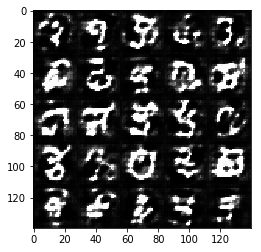

Epoch 1/2 Discriminator loss: 1.2065 Generator loss: 0.9500
Epoch 1/2 Discriminator loss: 1.1938 Generator loss: 0.8074
Epoch 1/2 Discriminator loss: 1.0924 Generator loss: 1.4281
Epoch 1/2 Discriminator loss: 1.1387 Generator loss: 0.9133
Epoch 1/2 Discriminator loss: 1.4026 Generator loss: 0.6047
Epoch 1/2 Discriminator loss: 1.2928 Generator loss: 1.0497
Epoch 1/2 Discriminator loss: 1.3712 Generator loss: 0.7118
Epoch 1/2 Discriminator loss: 1.3542 Generator loss: 0.7419
Epoch 1/2 Discriminator loss: 1.5188 Generator loss: 0.6978
Epoch 1/2 Discriminator loss: 1.2884 Generator loss: 1.0340
Epoch 1/2 Discriminator loss: 1.3084 Generator loss: 0.9186
Epoch 1/2 Discriminator loss: 1.3136 Generator loss: 0.7765
Epoch 1/2 Discriminator loss: 1.3112 Generator loss: 0.6636
Epoch 1/2 Discriminator loss: 1.6787 Generator loss: 0.8326
Epoch 1/2 Discriminator loss: 1.4835 Generator loss: 0.6191
Epoch 1/2 Discriminator loss: 1.3301 Generator loss: 0.8029
Epoch 1/2 Discriminator loss: 1.5483 Gen

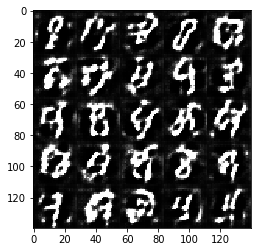

Epoch 1/2 Discriminator loss: 1.2002 Generator loss: 0.7548
Epoch 1/2 Discriminator loss: 1.3313 Generator loss: 1.1726
Epoch 1/2 Discriminator loss: 1.4270 Generator loss: 0.6920
Epoch 1/2 Discriminator loss: 1.4874 Generator loss: 0.8316
Epoch 1/2 Discriminator loss: 1.5064 Generator loss: 0.8390
Epoch 1/2 Discriminator loss: 1.5543 Generator loss: 0.5996
Epoch 1/2 Discriminator loss: 1.4092 Generator loss: 0.8869
Epoch 1/2 Discriminator loss: 1.2480 Generator loss: 0.9507
Epoch 1/2 Discriminator loss: 1.2960 Generator loss: 0.5814
Epoch 1/2 Discriminator loss: 1.1768 Generator loss: 1.0956
Epoch 1/2 Discriminator loss: 1.2735 Generator loss: 0.8446
Epoch 1/2 Discriminator loss: 1.0756 Generator loss: 0.9238
Epoch 1/2 Discriminator loss: 1.2740 Generator loss: 0.6903
Epoch 1/2 Discriminator loss: 1.3888 Generator loss: 1.0179
Epoch 1/2 Discriminator loss: 1.2891 Generator loss: 0.8580
Epoch 1/2 Discriminator loss: 1.4292 Generator loss: 0.5916
Epoch 1/2 Discriminator loss: 1.5707 Gen

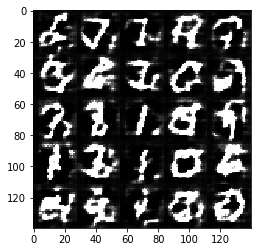

Epoch 1/2 Discriminator loss: 1.4120 Generator loss: 0.8074
Epoch 1/2 Discriminator loss: 1.4731 Generator loss: 0.7978
Epoch 1/2 Discriminator loss: 1.4589 Generator loss: 0.7152
Epoch 1/2 Discriminator loss: 1.3005 Generator loss: 0.9915
Epoch 1/2 Discriminator loss: 1.3341 Generator loss: 0.7523
Epoch 1/2 Discriminator loss: 1.2421 Generator loss: 0.8644
Epoch 1/2 Discriminator loss: 1.2517 Generator loss: 0.8443
Epoch 1/2 Discriminator loss: 1.2800 Generator loss: 0.6297
Epoch 1/2 Discriminator loss: 1.2826 Generator loss: 0.9826
Epoch 1/2 Discriminator loss: 1.3814 Generator loss: 0.8825
Epoch 1/2 Discriminator loss: 1.5541 Generator loss: 0.5639
Epoch 1/2 Discriminator loss: 1.3438 Generator loss: 1.0899
Epoch 1/2 Discriminator loss: 1.2627 Generator loss: 0.8093
Epoch 1/2 Discriminator loss: 1.4339 Generator loss: 0.5975
Epoch 1/2 Discriminator loss: 1.2952 Generator loss: 1.0196
Epoch 1/2 Discriminator loss: 1.3481 Generator loss: 0.8347
Epoch 1/2 Discriminator loss: 1.3732 Gen

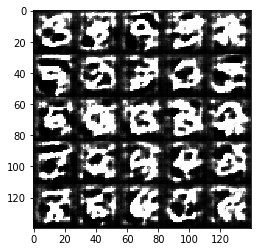

Epoch 1/2 Discriminator loss: 1.6207 Generator loss: 0.8736
Epoch 1/2 Discriminator loss: 1.4107 Generator loss: 0.6239
Epoch 1/2 Discriminator loss: 1.1664 Generator loss: 1.0159
Epoch 1/2 Discriminator loss: 1.0508 Generator loss: 1.0504
Epoch 1/2 Discriminator loss: 0.9085 Generator loss: 1.2346
Epoch 1/2 Discriminator loss: 0.8886 Generator loss: 1.2558
Epoch 1/2 Discriminator loss: 1.0213 Generator loss: 0.7939
Epoch 1/2 Discriminator loss: 1.0617 Generator loss: 1.5712
Epoch 1/2 Discriminator loss: 1.5083 Generator loss: 0.4704
Epoch 1/2 Discriminator loss: 1.3744 Generator loss: 0.9705
Epoch 1/2 Discriminator loss: 1.5495 Generator loss: 1.0908
Epoch 1/2 Discriminator loss: 1.6922 Generator loss: 0.3812
Epoch 1/2 Discriminator loss: 1.3048 Generator loss: 1.4577
Epoch 1/2 Discriminator loss: 1.1852 Generator loss: 0.6497
Epoch 1/2 Discriminator loss: 1.3319 Generator loss: 0.7377
Epoch 1/2 Discriminator loss: 1.2816 Generator loss: 1.4557
Epoch 1/2 Discriminator loss: 1.1426 Gen

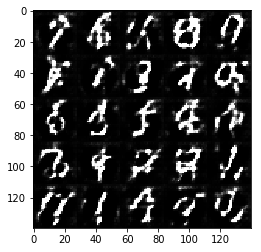

Epoch 1/2 Discriminator loss: 1.3683 Generator loss: 1.0713
Epoch 1/2 Discriminator loss: 1.0352 Generator loss: 0.9503
Epoch 1/2 Discriminator loss: 1.2691 Generator loss: 0.7604
Epoch 1/2 Discriminator loss: 1.1235 Generator loss: 1.0225
Epoch 1/2 Discriminator loss: 1.5557 Generator loss: 0.9632
Epoch 1/2 Discriminator loss: 1.6102 Generator loss: 0.5044
Epoch 1/2 Discriminator loss: 1.7300 Generator loss: 0.8287
Epoch 1/2 Discriminator loss: 1.7415 Generator loss: 0.6099
Epoch 1/2 Discriminator loss: 1.4339 Generator loss: 0.5701
Epoch 1/2 Discriminator loss: 1.5381 Generator loss: 1.3013
Epoch 1/2 Discriminator loss: 1.4078 Generator loss: 0.5227
Epoch 1/2 Discriminator loss: 1.1719 Generator loss: 0.9642
Epoch 1/2 Discriminator loss: 1.1643 Generator loss: 0.9703
Epoch 1/2 Discriminator loss: 1.3911 Generator loss: 0.7151
Epoch 1/2 Discriminator loss: 1.3740 Generator loss: 1.0871
Epoch 1/2 Discriminator loss: 1.1690 Generator loss: 0.8145
Epoch 1/2 Discriminator loss: 1.2948 Gen

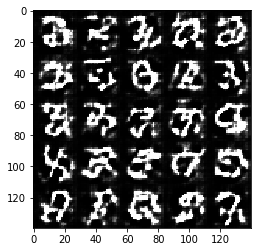

Epoch 1/2 Discriminator loss: 1.0216 Generator loss: 1.1614
Epoch 1/2 Discriminator loss: 1.3716 Generator loss: 0.8066
Epoch 1/2 Discriminator loss: 1.3244 Generator loss: 0.6732
Epoch 1/2 Discriminator loss: 1.5187 Generator loss: 0.9515
Epoch 1/2 Discriminator loss: 1.5328 Generator loss: 0.4204
Epoch 1/2 Discriminator loss: 1.6638 Generator loss: 1.3389
Epoch 1/2 Discriminator loss: 1.5806 Generator loss: 0.5000
Epoch 1/2 Discriminator loss: 1.3539 Generator loss: 0.8870
Epoch 1/2 Discriminator loss: 1.3054 Generator loss: 1.1157
Epoch 1/2 Discriminator loss: 1.2578 Generator loss: 0.7747
Epoch 1/2 Discriminator loss: 1.1775 Generator loss: 1.2120
Epoch 1/2 Discriminator loss: 1.1324 Generator loss: 0.7756
Epoch 1/2 Discriminator loss: 1.1309 Generator loss: 0.8685
Epoch 1/2 Discriminator loss: 1.1455 Generator loss: 1.3220
Epoch 1/2 Discriminator loss: 1.4172 Generator loss: 0.5464
Epoch 1/2 Discriminator loss: 1.5456 Generator loss: 1.1353
Epoch 1/2 Discriminator loss: 1.3872 Gen

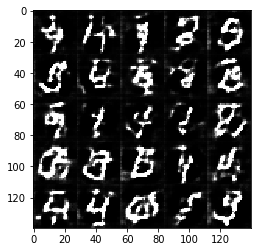

Epoch 1/2 Discriminator loss: 1.1523 Generator loss: 0.7700
Epoch 1/2 Discriminator loss: 1.0355 Generator loss: 1.2626
Epoch 1/2 Discriminator loss: 1.1665 Generator loss: 0.6466
Epoch 1/2 Discriminator loss: 1.3530 Generator loss: 1.1036
Epoch 1/2 Discriminator loss: 1.4777 Generator loss: 0.7267
Epoch 1/2 Discriminator loss: 1.4518 Generator loss: 0.5335
Epoch 1/2 Discriminator loss: 1.3042 Generator loss: 1.2890
Epoch 1/2 Discriminator loss: 1.5306 Generator loss: 0.4725
Epoch 2/2 Discriminator loss: 1.3176 Generator loss: 1.2500
Epoch 2/2 Discriminator loss: 1.2177 Generator loss: 0.7918
Epoch 2/2 Discriminator loss: 1.3112 Generator loss: 0.6891
Epoch 2/2 Discriminator loss: 1.2993 Generator loss: 0.7700
Epoch 2/2 Discriminator loss: 1.1821 Generator loss: 0.9633
Epoch 2/2 Discriminator loss: 1.3359 Generator loss: 0.5894
Epoch 2/2 Discriminator loss: 1.2307 Generator loss: 1.1917
Epoch 2/2 Discriminator loss: 1.5530 Generator loss: 0.5036
Epoch 2/2 Discriminator loss: 1.1398 Gen

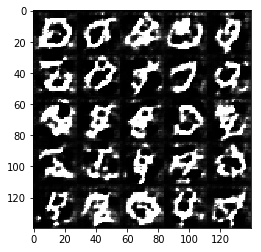

Epoch 2/2 Discriminator loss: 1.2612 Generator loss: 0.8004
Epoch 2/2 Discriminator loss: 1.2394 Generator loss: 0.8069
Epoch 2/2 Discriminator loss: 1.3086 Generator loss: 0.9241
Epoch 2/2 Discriminator loss: 1.3646 Generator loss: 0.5746
Epoch 2/2 Discriminator loss: 1.4070 Generator loss: 1.0897
Epoch 2/2 Discriminator loss: 1.2679 Generator loss: 0.8628
Epoch 2/2 Discriminator loss: 1.1703 Generator loss: 0.8348
Epoch 2/2 Discriminator loss: 1.1494 Generator loss: 0.9870
Epoch 2/2 Discriminator loss: 1.0206 Generator loss: 0.9490
Epoch 2/2 Discriminator loss: 1.2186 Generator loss: 0.6729
Epoch 2/2 Discriminator loss: 1.3248 Generator loss: 1.0676
Epoch 2/2 Discriminator loss: 1.5042 Generator loss: 0.5711
Epoch 2/2 Discriminator loss: 1.3482 Generator loss: 0.8615
Epoch 2/2 Discriminator loss: 1.3847 Generator loss: 0.7211
Epoch 2/2 Discriminator loss: 1.4751 Generator loss: 1.0393
Epoch 2/2 Discriminator loss: 1.4060 Generator loss: 0.5528
Epoch 2/2 Discriminator loss: 1.6639 Gen

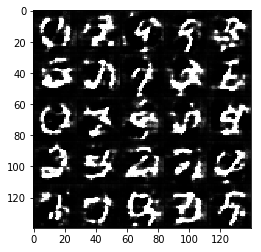

Epoch 2/2 Discriminator loss: 1.2186 Generator loss: 0.8954
Epoch 2/2 Discriminator loss: 1.1060 Generator loss: 1.2132
Epoch 2/2 Discriminator loss: 1.0866 Generator loss: 0.7551
Epoch 2/2 Discriminator loss: 1.0583 Generator loss: 1.2606
Epoch 2/2 Discriminator loss: 1.1342 Generator loss: 0.7439
Epoch 2/2 Discriminator loss: 1.1052 Generator loss: 1.1595
Epoch 2/2 Discriminator loss: 1.1480 Generator loss: 0.8673
Epoch 2/2 Discriminator loss: 1.2337 Generator loss: 0.6801
Epoch 2/2 Discriminator loss: 1.2573 Generator loss: 1.2039
Epoch 2/2 Discriminator loss: 1.2713 Generator loss: 0.6603
Epoch 2/2 Discriminator loss: 1.3473 Generator loss: 1.2827
Epoch 2/2 Discriminator loss: 1.8368 Generator loss: 0.2807
Epoch 2/2 Discriminator loss: 1.7112 Generator loss: 1.4119
Epoch 2/2 Discriminator loss: 1.4957 Generator loss: 0.3846
Epoch 2/2 Discriminator loss: 1.3696 Generator loss: 1.0322
Epoch 2/2 Discriminator loss: 1.1511 Generator loss: 0.7607
Epoch 2/2 Discriminator loss: 1.2952 Gen

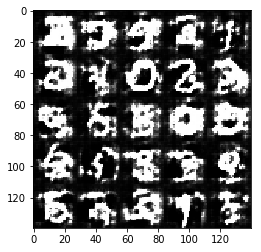

Epoch 2/2 Discriminator loss: 1.3085 Generator loss: 0.8576
Epoch 2/2 Discriminator loss: 1.2669 Generator loss: 1.0608
Epoch 2/2 Discriminator loss: 1.3192 Generator loss: 0.7211
Epoch 2/2 Discriminator loss: 1.0300 Generator loss: 1.2246
Epoch 2/2 Discriminator loss: 1.0154 Generator loss: 0.8938
Epoch 2/2 Discriminator loss: 1.1730 Generator loss: 1.2104
Epoch 2/2 Discriminator loss: 1.2008 Generator loss: 0.7533
Epoch 2/2 Discriminator loss: 1.1658 Generator loss: 1.2384
Epoch 2/2 Discriminator loss: 1.2400 Generator loss: 0.6668
Epoch 2/2 Discriminator loss: 1.0539 Generator loss: 1.0183
Epoch 2/2 Discriminator loss: 1.2257 Generator loss: 0.8075
Epoch 2/2 Discriminator loss: 1.2454 Generator loss: 1.0567
Epoch 2/2 Discriminator loss: 1.1981 Generator loss: 0.8111
Epoch 2/2 Discriminator loss: 1.0879 Generator loss: 1.3051
Epoch 2/2 Discriminator loss: 1.1959 Generator loss: 0.9771
Epoch 2/2 Discriminator loss: 1.4204 Generator loss: 0.9626
Epoch 2/2 Discriminator loss: 1.4039 Gen

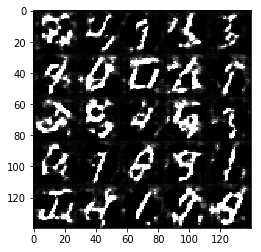

Epoch 2/2 Discriminator loss: 1.4896 Generator loss: 0.3779
Epoch 2/2 Discriminator loss: 1.1675 Generator loss: 0.8504
Epoch 2/2 Discriminator loss: 1.2102 Generator loss: 1.4557
Epoch 2/2 Discriminator loss: 1.2582 Generator loss: 0.5849
Epoch 2/2 Discriminator loss: 1.1345 Generator loss: 0.9291
Epoch 2/2 Discriminator loss: 1.0623 Generator loss: 1.2727
Epoch 2/2 Discriminator loss: 1.0532 Generator loss: 1.0131
Epoch 2/2 Discriminator loss: 1.1135 Generator loss: 0.7550
Epoch 2/2 Discriminator loss: 1.2910 Generator loss: 0.7693
Epoch 2/2 Discriminator loss: 1.1392 Generator loss: 1.1335
Epoch 2/2 Discriminator loss: 1.3909 Generator loss: 0.5495
Epoch 2/2 Discriminator loss: 1.3344 Generator loss: 1.1383
Epoch 2/2 Discriminator loss: 1.2854 Generator loss: 0.5441
Epoch 2/2 Discriminator loss: 1.4208 Generator loss: 0.8165
Epoch 2/2 Discriminator loss: 1.0683 Generator loss: 1.0187
Epoch 2/2 Discriminator loss: 1.1805 Generator loss: 0.7811
Epoch 2/2 Discriminator loss: 0.8988 Gen

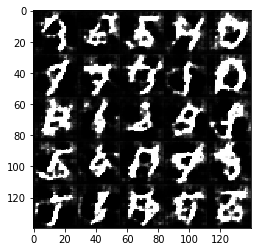

Epoch 2/2 Discriminator loss: 1.1987 Generator loss: 1.3571
Epoch 2/2 Discriminator loss: 1.2394 Generator loss: 0.5921
Epoch 2/2 Discriminator loss: 1.2440 Generator loss: 1.2915
Epoch 2/2 Discriminator loss: 1.3266 Generator loss: 0.6916
Epoch 2/2 Discriminator loss: 1.3021 Generator loss: 1.0921
Epoch 2/2 Discriminator loss: 1.2311 Generator loss: 0.8146
Epoch 2/2 Discriminator loss: 1.2716 Generator loss: 1.1116
Epoch 2/2 Discriminator loss: 1.3417 Generator loss: 0.5151
Epoch 2/2 Discriminator loss: 1.2772 Generator loss: 1.5449
Epoch 2/2 Discriminator loss: 1.1836 Generator loss: 0.9316
Epoch 2/2 Discriminator loss: 1.4591 Generator loss: 0.4660
Epoch 2/2 Discriminator loss: 1.6476 Generator loss: 1.5214
Epoch 2/2 Discriminator loss: 1.5083 Generator loss: 0.3807
Epoch 2/2 Discriminator loss: 1.2151 Generator loss: 1.2500
Epoch 2/2 Discriminator loss: 1.1313 Generator loss: 0.8240
Epoch 2/2 Discriminator loss: 1.4477 Generator loss: 0.6325
Epoch 2/2 Discriminator loss: 1.1944 Gen

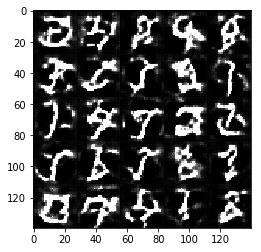

Epoch 2/2 Discriminator loss: 1.4610 Generator loss: 0.5754
Epoch 2/2 Discriminator loss: 1.3548 Generator loss: 1.0285
Epoch 2/2 Discriminator loss: 1.1574 Generator loss: 0.9199
Epoch 2/2 Discriminator loss: 1.2136 Generator loss: 0.7387
Epoch 2/2 Discriminator loss: 1.1262 Generator loss: 1.1995
Epoch 2/2 Discriminator loss: 1.2457 Generator loss: 0.6536
Epoch 2/2 Discriminator loss: 1.0836 Generator loss: 1.0822
Epoch 2/2 Discriminator loss: 1.2263 Generator loss: 0.6229
Epoch 2/2 Discriminator loss: 1.1910 Generator loss: 0.9883
Epoch 2/2 Discriminator loss: 1.2765 Generator loss: 0.7904
Epoch 2/2 Discriminator loss: 1.2182 Generator loss: 1.0997
Epoch 2/2 Discriminator loss: 1.4363 Generator loss: 0.5255
Epoch 2/2 Discriminator loss: 1.1670 Generator loss: 1.3431
Epoch 2/2 Discriminator loss: 1.4334 Generator loss: 0.4421
Epoch 2/2 Discriminator loss: 1.5066 Generator loss: 1.7562
Epoch 2/2 Discriminator loss: 1.4379 Generator loss: 0.3585
Epoch 2/2 Discriminator loss: 1.1276 Gen

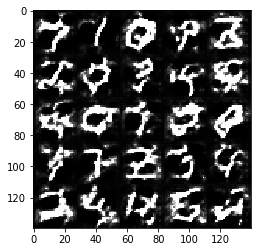

Epoch 2/2 Discriminator loss: 1.2230 Generator loss: 0.9196
Epoch 2/2 Discriminator loss: 1.2443 Generator loss: 0.8006
Epoch 2/2 Discriminator loss: 1.3945 Generator loss: 0.7995
Epoch 2/2 Discriminator loss: 1.3065 Generator loss: 0.8230
Epoch 2/2 Discriminator loss: 1.3572 Generator loss: 0.6822
Epoch 2/2 Discriminator loss: 1.2700 Generator loss: 0.9418
Epoch 2/2 Discriminator loss: 1.2251 Generator loss: 0.6081
Epoch 2/2 Discriminator loss: 1.3629 Generator loss: 1.3024
Epoch 2/2 Discriminator loss: 1.2686 Generator loss: 0.6015
Epoch 2/2 Discriminator loss: 1.1133 Generator loss: 0.9907
Epoch 2/2 Discriminator loss: 1.2979 Generator loss: 0.9449
Epoch 2/2 Discriminator loss: 1.4510 Generator loss: 0.4440
Epoch 2/2 Discriminator loss: 1.2699 Generator loss: 1.3679
Epoch 2/2 Discriminator loss: 1.5493 Generator loss: 0.5043
Epoch 2/2 Discriminator loss: 1.0934 Generator loss: 1.1964
Epoch 2/2 Discriminator loss: 1.1586 Generator loss: 0.6882
Epoch 2/2 Discriminator loss: 1.0350 Gen

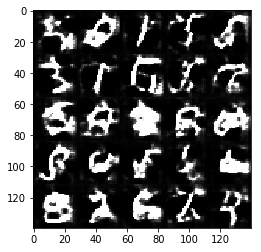

Epoch 2/2 Discriminator loss: 1.3717 Generator loss: 0.5513
Epoch 2/2 Discriminator loss: 1.2986 Generator loss: 1.0835
Epoch 2/2 Discriminator loss: 1.2267 Generator loss: 0.7085
Epoch 2/2 Discriminator loss: 1.4598 Generator loss: 1.2671
Epoch 2/2 Discriminator loss: 1.4734 Generator loss: 0.4866
Epoch 2/2 Discriminator loss: 1.4498 Generator loss: 0.9952
Epoch 2/2 Discriminator loss: 1.4191 Generator loss: 0.5837
Epoch 2/2 Discriminator loss: 1.3548 Generator loss: 1.0279
Epoch 2/2 Discriminator loss: 1.3127 Generator loss: 0.7693
Epoch 2/2 Discriminator loss: 1.3113 Generator loss: 0.7420
Epoch 2/2 Discriminator loss: 1.1679 Generator loss: 1.1495
Epoch 2/2 Discriminator loss: 1.3900 Generator loss: 0.6210
Epoch 2/2 Discriminator loss: 1.6794 Generator loss: 1.2447
Epoch 2/2 Discriminator loss: 1.4921 Generator loss: 0.4300
Epoch 2/2 Discriminator loss: 1.3324 Generator loss: 1.1216
Epoch 2/2 Discriminator loss: 1.2007 Generator loss: 0.6439
Epoch 2/2 Discriminator loss: 1.0318 Gen

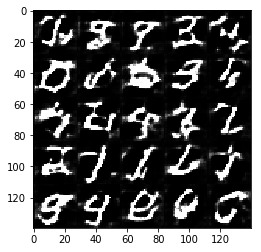

Epoch 2/2 Discriminator loss: 1.2755 Generator loss: 0.9789
Epoch 2/2 Discriminator loss: 1.0361 Generator loss: 0.9093
Epoch 2/2 Discriminator loss: 1.3757 Generator loss: 1.1648
Epoch 2/2 Discriminator loss: 0.9771 Generator loss: 0.8292
Epoch 2/2 Discriminator loss: 1.2817 Generator loss: 0.9440
Epoch 2/2 Discriminator loss: 1.3122 Generator loss: 0.9132
Epoch 2/2 Discriminator loss: 1.2521 Generator loss: 0.9354
Epoch 2/2 Discriminator loss: 1.5109 Generator loss: 0.5650
Epoch 2/2 Discriminator loss: 1.6153 Generator loss: 1.2876
Epoch 2/2 Discriminator loss: 1.8172 Generator loss: 0.2452
Epoch 2/2 Discriminator loss: 1.2546 Generator loss: 1.6076
Epoch 2/2 Discriminator loss: 1.0514 Generator loss: 0.8797
Epoch 2/2 Discriminator loss: 1.2236 Generator loss: 0.8005
Epoch 2/2 Discriminator loss: 1.3567 Generator loss: 0.7937
Epoch 2/2 Discriminator loss: 1.2799 Generator loss: 0.8390
Epoch 2/2 Discriminator loss: 1.2119 Generator loss: 0.7224
Epoch 2/2 Discriminator loss: 1.3186 Gen

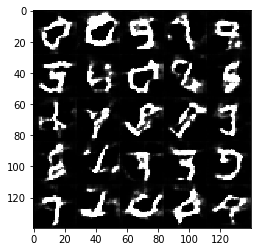

Epoch 2/2 Discriminator loss: 1.3646 Generator loss: 0.9120
Epoch 2/2 Discriminator loss: 1.4933 Generator loss: 0.5048
Epoch 2/2 Discriminator loss: 1.5836 Generator loss: 1.2787
Epoch 2/2 Discriminator loss: 1.6463 Generator loss: 0.3302
Epoch 2/2 Discriminator loss: 1.3993 Generator loss: 0.9487
Epoch 2/2 Discriminator loss: 1.4388 Generator loss: 0.6478
Epoch 2/2 Discriminator loss: 1.2726 Generator loss: 0.9222
Epoch 2/2 Discriminator loss: 1.4840 Generator loss: 0.4908
Epoch 2/2 Discriminator loss: 1.2239 Generator loss: 1.3413
Epoch 2/2 Discriminator loss: 1.3094 Generator loss: 0.5126
Epoch 2/2 Discriminator loss: 1.3113 Generator loss: 0.8646
Epoch 2/2 Discriminator loss: 1.3565 Generator loss: 0.9832
Epoch 2/2 Discriminator loss: 1.3085 Generator loss: 0.5374
Epoch 2/2 Discriminator loss: 1.4740 Generator loss: 1.4731
Epoch 2/2 Discriminator loss: 1.5438 Generator loss: 0.3015
Epoch 2/2 Discriminator loss: 1.5495 Generator loss: 1.0824
Epoch 2/2 Discriminator loss: 1.1817 Gen

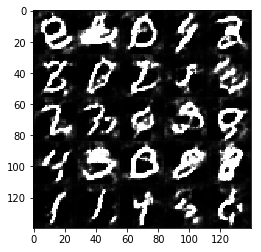

Epoch 2/2 Discriminator loss: 1.3577 Generator loss: 0.6314
Epoch 2/2 Discriminator loss: 1.2402 Generator loss: 1.1214
Epoch 2/2 Discriminator loss: 1.2635 Generator loss: 0.5815
Epoch 2/2 Discriminator loss: 1.2569 Generator loss: 1.0652
Epoch 2/2 Discriminator loss: 1.1311 Generator loss: 0.9124
Epoch 2/2 Discriminator loss: 1.1207 Generator loss: 0.9003
Epoch 2/2 Discriminator loss: 1.0084 Generator loss: 1.1791
Epoch 2/2 Discriminator loss: 1.2834 Generator loss: 0.7415
Epoch 2/2 Discriminator loss: 1.2238 Generator loss: 1.2822
Epoch 2/2 Discriminator loss: 1.2533 Generator loss: 0.5876
Epoch 2/2 Discriminator loss: 1.1369 Generator loss: 1.3801
Epoch 2/2 Discriminator loss: 1.2030 Generator loss: 0.6732
Epoch 2/2 Discriminator loss: 1.3241 Generator loss: 0.9317
Epoch 2/2 Discriminator loss: 1.7384 Generator loss: 0.6089
Epoch 2/2 Discriminator loss: 1.4533 Generator loss: 0.7309
Epoch 2/2 Discriminator loss: 1.5197 Generator loss: 1.0657
Epoch 2/2 Discriminator loss: 1.5916 Gen

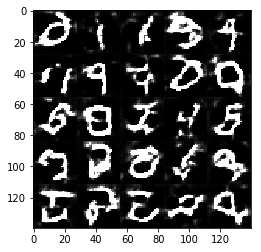

Epoch 2/2 Discriminator loss: 1.2305 Generator loss: 0.5939
Epoch 2/2 Discriminator loss: 1.0061 Generator loss: 1.1195
Epoch 2/2 Discriminator loss: 1.1158 Generator loss: 1.0885
Epoch 2/2 Discriminator loss: 1.0079 Generator loss: 1.0005
Epoch 2/2 Discriminator loss: 1.0488 Generator loss: 0.9077
Epoch 2/2 Discriminator loss: 1.2983 Generator loss: 0.9628
Epoch 2/2 Discriminator loss: 1.3536 Generator loss: 0.5951
Epoch 2/2 Discriminator loss: 1.6820 Generator loss: 0.4567
Epoch 2/2 Discriminator loss: 1.8713 Generator loss: 2.1157
Epoch 2/2 Discriminator loss: 1.8981 Generator loss: 0.2417
Epoch 2/2 Discriminator loss: 1.0781 Generator loss: 0.9180
Epoch 2/2 Discriminator loss: 1.1023 Generator loss: 1.5324
Epoch 2/2 Discriminator loss: 1.1141 Generator loss: 0.6777
Epoch 2/2 Discriminator loss: 1.2422 Generator loss: 0.9451
Epoch 2/2 Discriminator loss: 1.2922 Generator loss: 0.8086
Epoch 2/2 Discriminator loss: 1.2649 Generator loss: 0.7469
Epoch 2/2 Discriminator loss: 1.3732 Gen

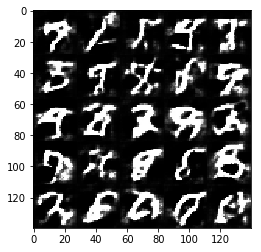

Epoch 2/2 Discriminator loss: 1.1436 Generator loss: 1.0322
Epoch 2/2 Discriminator loss: 1.3532 Generator loss: 0.7632
Epoch 2/2 Discriminator loss: 1.2614 Generator loss: 0.8482
Epoch 2/2 Discriminator loss: 1.1658 Generator loss: 1.1745
Epoch 2/2 Discriminator loss: 1.1486 Generator loss: 0.9579
Epoch 2/2 Discriminator loss: 1.1747 Generator loss: 0.7459
Epoch 2/2 Discriminator loss: 1.3160 Generator loss: 0.8205
Epoch 2/2 Discriminator loss: 1.2551 Generator loss: 0.7640
Epoch 2/2 Discriminator loss: 1.3640 Generator loss: 0.9282
Epoch 2/2 Discriminator loss: 1.2629 Generator loss: 1.2837
Epoch 2/2 Discriminator loss: 1.2366 Generator loss: 0.5465
Epoch 2/2 Discriminator loss: 1.1627 Generator loss: 1.6019
Epoch 2/2 Discriminator loss: 1.0879 Generator loss: 0.7741
Epoch 2/2 Discriminator loss: 0.9938 Generator loss: 0.8066
Epoch 2/2 Discriminator loss: 1.2557 Generator loss: 1.4546
Epoch 2/2 Discriminator loss: 1.3592 Generator loss: 0.4042
Epoch 2/2 Discriminator loss: 1.5685 Gen

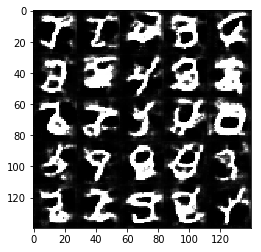

Epoch 2/2 Discriminator loss: 1.5501 Generator loss: 0.3871
Epoch 2/2 Discriminator loss: 1.2363 Generator loss: 1.1959
Epoch 2/2 Discriminator loss: 1.2821 Generator loss: 0.7721
Epoch 2/2 Discriminator loss: 1.4026 Generator loss: 0.7370
Epoch 2/2 Discriminator loss: 1.2817 Generator loss: 0.7918
Epoch 2/2 Discriminator loss: 1.2478 Generator loss: 0.9032
Epoch 2/2 Discriminator loss: 1.2573 Generator loss: 0.7373
Epoch 2/2 Discriminator loss: 1.3631 Generator loss: 0.8932
Epoch 2/2 Discriminator loss: 1.2854 Generator loss: 0.7145
Epoch 2/2 Discriminator loss: 1.3907 Generator loss: 0.9829
Epoch 2/2 Discriminator loss: 1.1387 Generator loss: 0.7948
Epoch 2/2 Discriminator loss: 1.3232 Generator loss: 0.6540
Epoch 2/2 Discriminator loss: 1.3967 Generator loss: 0.6929
Epoch 2/2 Discriminator loss: 1.4456 Generator loss: 1.1909
Epoch 2/2 Discriminator loss: 1.3735 Generator loss: 0.6448
Epoch 2/2 Discriminator loss: 1.5165 Generator loss: 0.5611
Epoch 2/2 Discriminator loss: 1.2540 Gen

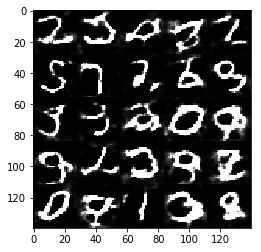

Epoch 2/2 Discriminator loss: 1.3892 Generator loss: 0.6011
Epoch 2/2 Discriminator loss: 1.1185 Generator loss: 0.8721
Epoch 2/2 Discriminator loss: 1.1595 Generator loss: 0.6984
Epoch 2/2 Discriminator loss: 1.2894 Generator loss: 1.0918
Epoch 2/2 Discriminator loss: 1.3689 Generator loss: 0.5394
Epoch 2/2 Discriminator loss: 1.4688 Generator loss: 1.4958
Epoch 2/2 Discriminator loss: 1.3931 Generator loss: 0.5134
Epoch 2/2 Discriminator loss: 1.3560 Generator loss: 1.2274
Epoch 2/2 Discriminator loss: 1.4449 Generator loss: 0.4990
Epoch 2/2 Discriminator loss: 1.4009 Generator loss: 1.1542
Epoch 2/2 Discriminator loss: 1.4547 Generator loss: 0.7175
Epoch 2/2 Discriminator loss: 1.3220 Generator loss: 0.6675
Epoch 2/2 Discriminator loss: 1.4028 Generator loss: 0.8735
Epoch 2/2 Discriminator loss: 1.4140 Generator loss: 0.5671
Epoch 2/2 Discriminator loss: 1.1262 Generator loss: 1.4329
Epoch 2/2 Discriminator loss: 1.1470 Generator loss: 0.7851
Epoch 2/2 Discriminator loss: 1.3376 Gen

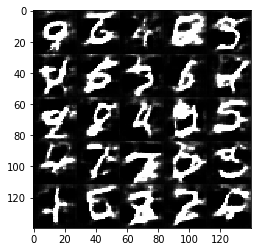

Epoch 2/2 Discriminator loss: 1.4869 Generator loss: 0.7017
Epoch 2/2 Discriminator loss: 1.1855 Generator loss: 1.3876
Epoch 2/2 Discriminator loss: 1.2158 Generator loss: 0.5689
Epoch 2/2 Discriminator loss: 1.5176 Generator loss: 1.2897
Epoch 2/2 Discriminator loss: 1.4742 Generator loss: 0.3934
Epoch 2/2 Discriminator loss: 1.5792 Generator loss: 1.4382
Epoch 2/2 Discriminator loss: 1.1384 Generator loss: 0.7633
Epoch 2/2 Discriminator loss: 1.2608 Generator loss: 0.7652
Epoch 2/2 Discriminator loss: 1.2900 Generator loss: 0.9545
Epoch 2/2 Discriminator loss: 1.2009 Generator loss: 0.8934
Epoch 2/2 Discriminator loss: 1.0302 Generator loss: 0.5025
Epoch 2/2 Discriminator loss: 1.2044 Generator loss: 1.1552
Epoch 2/2 Discriminator loss: 1.1502 Generator loss: 0.9193
Epoch 2/2 Discriminator loss: 1.0799 Generator loss: 0.7921
Epoch 2/2 Discriminator loss: 1.3518 Generator loss: 0.9880
Epoch 2/2 Discriminator loss: 1.2530 Generator loss: 0.6603
Epoch 2/2 Discriminator loss: 1.2257 Gen

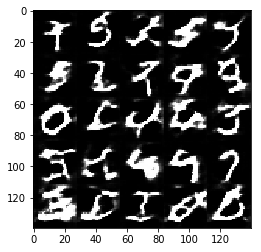

Epoch 2/2 Discriminator loss: 1.4356 Generator loss: 0.7541
Epoch 2/2 Discriminator loss: 1.3803 Generator loss: 0.6079
Epoch 2/2 Discriminator loss: 1.2964 Generator loss: 0.9459
Epoch 2/2 Discriminator loss: 1.3864 Generator loss: 0.6805
Epoch 2/2 Discriminator loss: 1.0805 Generator loss: 0.9188
Epoch 2/2 Discriminator loss: 1.1796 Generator loss: 0.9893
Epoch 2/2 Discriminator loss: 1.0899 Generator loss: 1.0351
Epoch 2/2 Discriminator loss: 1.2289 Generator loss: 0.7274
Epoch 2/2 Discriminator loss: 1.1664 Generator loss: 0.6984
Epoch 2/2 Discriminator loss: 1.4561 Generator loss: 1.2468
Epoch 2/2 Discriminator loss: 1.3983 Generator loss: 0.4337
Epoch 2/2 Discriminator loss: 1.4908 Generator loss: 1.5066
Epoch 2/2 Discriminator loss: 1.3735 Generator loss: 0.5719
Epoch 2/2 Discriminator loss: 1.3492 Generator loss: 1.4143
Epoch 2/2 Discriminator loss: 1.2241 Generator loss: 0.7537
Epoch 2/2 Discriminator loss: 1.3316 Generator loss: 1.0764
Epoch 2/2 Discriminator loss: 1.4511 Gen

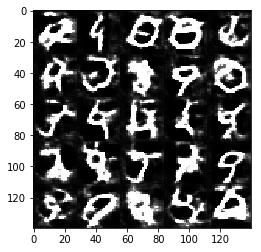

Epoch 2/2 Discriminator loss: 1.2209 Generator loss: 1.0728
Epoch 2/2 Discriminator loss: 1.1867 Generator loss: 0.7339
Epoch 2/2 Discriminator loss: 1.5510 Generator loss: 1.2886
Epoch 2/2 Discriminator loss: 1.5783 Generator loss: 0.3721
Epoch 2/2 Discriminator loss: 1.6020 Generator loss: 1.3017
Epoch 2/2 Discriminator loss: 1.4014 Generator loss: 0.4587
Epoch 2/2 Discriminator loss: 1.4022 Generator loss: 0.9194
Epoch 2/2 Discriminator loss: 1.1640 Generator loss: 1.0235
Epoch 2/2 Discriminator loss: 1.2547 Generator loss: 0.7176
Epoch 2/2 Discriminator loss: 1.2031 Generator loss: 0.8826
Epoch 2/2 Discriminator loss: 1.0199 Generator loss: 1.3482
Epoch 2/2 Discriminator loss: 1.1836 Generator loss: 0.6894
Epoch 2/2 Discriminator loss: 1.3303 Generator loss: 1.0687
Epoch 2/2 Discriminator loss: 1.1635 Generator loss: 0.8621
Epoch 2/2 Discriminator loss: 1.2545 Generator loss: 0.8062
Epoch 2/2 Discriminator loss: 1.1263 Generator loss: 1.1986
Epoch 2/2 Discriminator loss: 1.2682 Gen

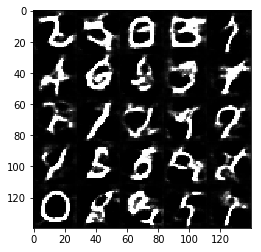

Epoch 2/2 Discriminator loss: 1.1627 Generator loss: 1.0747
Epoch 2/2 Discriminator loss: 1.1164 Generator loss: 0.6728
Epoch 2/2 Discriminator loss: 1.0434 Generator loss: 0.9541
Epoch 2/2 Discriminator loss: 1.3404 Generator loss: 0.5866
Epoch 2/2 Discriminator loss: 1.5262 Generator loss: 0.9226
Epoch 2/2 Discriminator loss: 1.4840 Generator loss: 0.4642
Epoch 2/2 Discriminator loss: 1.7019 Generator loss: 1.7933
Epoch 2/2 Discriminator loss: 1.7560 Generator loss: 0.2678
Epoch 2/2 Discriminator loss: 1.3771 Generator loss: 1.2474
Epoch 2/2 Discriminator loss: 1.3682 Generator loss: 0.7112
Epoch 2/2 Discriminator loss: 1.4173 Generator loss: 0.5981
Epoch 2/2 Discriminator loss: 1.3018 Generator loss: 0.9862
Epoch 2/2 Discriminator loss: 1.4053 Generator loss: 0.4766
Epoch 2/2 Discriminator loss: 1.3081 Generator loss: 1.3496
Epoch 2/2 Discriminator loss: 1.3731 Generator loss: 0.5328
Epoch 2/2 Discriminator loss: 1.1792 Generator loss: 0.7630
Epoch 2/2 Discriminator loss: 1.4728 Gen

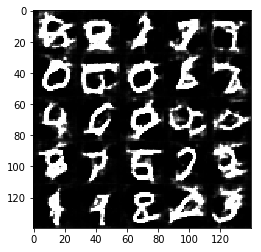

Epoch 2/2 Discriminator loss: 1.4905 Generator loss: 1.1876
Epoch 2/2 Discriminator loss: 1.3766 Generator loss: 0.6712
Epoch 2/2 Discriminator loss: 1.3090 Generator loss: 0.9063
Epoch 2/2 Discriminator loss: 1.2261 Generator loss: 0.9586
Epoch 2/2 Discriminator loss: 1.2407 Generator loss: 0.5322
Epoch 2/2 Discriminator loss: 1.1579 Generator loss: 1.0863
Epoch 2/2 Discriminator loss: 0.9790 Generator loss: 1.1860
Epoch 2/2 Discriminator loss: 1.3308 Generator loss: 0.4712
Epoch 2/2 Discriminator loss: 1.1732 Generator loss: 1.0926
Epoch 2/2 Discriminator loss: 1.2221 Generator loss: 0.7799
Epoch 2/2 Discriminator loss: 1.1545 Generator loss: 0.8012
Epoch 2/2 Discriminator loss: 1.0013 Generator loss: 0.8705
Epoch 2/2 Discriminator loss: 1.2589 Generator loss: 0.7629
Epoch 2/2 Discriminator loss: 1.2189 Generator loss: 0.9477
Epoch 2/2 Discriminator loss: 1.1998 Generator loss: 1.0324
Epoch 2/2 Discriminator loss: 1.4338 Generator loss: 0.6424
Epoch 2/2 Discriminator loss: 1.3492 Gen

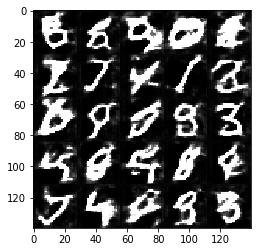

Epoch 2/2 Discriminator loss: 1.1160 Generator loss: 1.0811
Epoch 2/2 Discriminator loss: 1.4828 Generator loss: 0.3337
Epoch 2/2 Discriminator loss: 1.7602 Generator loss: 2.1350
Epoch 2/2 Discriminator loss: 1.8452 Generator loss: 0.2686
Epoch 2/2 Discriminator loss: 1.1901 Generator loss: 1.0744
Epoch 2/2 Discriminator loss: 1.1490 Generator loss: 1.2677
Epoch 2/2 Discriminator loss: 1.1407 Generator loss: 0.7572
Epoch 2/2 Discriminator loss: 1.2742 Generator loss: 0.7801
Epoch 2/2 Discriminator loss: 1.2715 Generator loss: 0.9153
Epoch 2/2 Discriminator loss: 1.4180 Generator loss: 0.7489
Epoch 2/2 Discriminator loss: 1.3832 Generator loss: 0.6790
Epoch 2/2 Discriminator loss: 1.2750 Generator loss: 0.8355
Epoch 2/2 Discriminator loss: 1.3248 Generator loss: 1.0693
Epoch 2/2 Discriminator loss: 1.3329 Generator loss: 0.6914
Epoch 2/2 Discriminator loss: 1.1000 Generator loss: 1.2329
Epoch 2/2 Discriminator loss: 1.3483 Generator loss: 0.6273
Epoch 2/2 Discriminator loss: 1.3734 Gen

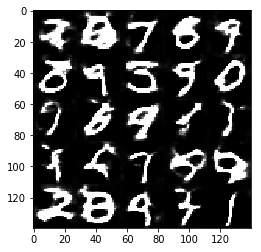

Epoch 2/2 Discriminator loss: 1.0928 Generator loss: 1.0253
Epoch 2/2 Discriminator loss: 1.2697 Generator loss: 0.7437
Epoch 2/2 Discriminator loss: 1.3588 Generator loss: 0.7621
Epoch 2/2 Discriminator loss: 1.0127 Generator loss: 0.8631
Epoch 2/2 Discriminator loss: 1.1732 Generator loss: 0.8657
Epoch 2/2 Discriminator loss: 1.3019 Generator loss: 1.3206
Epoch 2/2 Discriminator loss: 1.5850 Generator loss: 0.3520
Epoch 2/2 Discriminator loss: 1.2377 Generator loss: 1.6012
Epoch 2/2 Discriminator loss: 1.1231 Generator loss: 0.7234
Epoch 2/2 Discriminator loss: 1.0726 Generator loss: 1.0322
Epoch 2/2 Discriminator loss: 1.0679 Generator loss: 0.9996
Epoch 2/2 Discriminator loss: 1.1572 Generator loss: 0.7524
Epoch 2/2 Discriminator loss: 1.1196 Generator loss: 0.8075
Epoch 2/2 Discriminator loss: 1.4392 Generator loss: 0.4490
Epoch 2/2 Discriminator loss: 1.3789 Generator loss: 1.3857
Epoch 2/2 Discriminator loss: 1.7336 Generator loss: 0.3424
Epoch 2/2 Discriminator loss: 1.1851 Gen

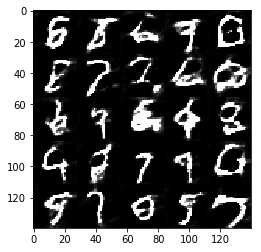

Epoch 2/2 Discriminator loss: 1.5865 Generator loss: 0.4399
Epoch 2/2 Discriminator loss: 1.3909 Generator loss: 1.0970
Epoch 2/2 Discriminator loss: 1.3797 Generator loss: 0.7303
Epoch 2/2 Discriminator loss: 1.3440 Generator loss: 0.6947
Epoch 2/2 Discriminator loss: 1.3328 Generator loss: 0.8971
Epoch 2/2 Discriminator loss: 1.3317 Generator loss: 0.8086
Epoch 2/2 Discriminator loss: 1.1828 Generator loss: 0.7496
Epoch 2/2 Discriminator loss: 1.1963 Generator loss: 0.7923
Epoch 2/2 Discriminator loss: 1.2200 Generator loss: 0.6789
Epoch 2/2 Discriminator loss: 1.1054 Generator loss: 1.0563
Epoch 2/2 Discriminator loss: 1.0312 Generator loss: 0.8470
Epoch 2/2 Discriminator loss: 1.4657 Generator loss: 0.5014
Epoch 2/2 Discriminator loss: 1.2558 Generator loss: 1.5244
Epoch 2/2 Discriminator loss: 1.7154 Generator loss: 0.3573
Epoch 2/2 Discriminator loss: 1.4969 Generator loss: 1.4696
Epoch 2/2 Discriminator loss: 1.5407 Generator loss: 0.5179


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = .0002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Discriminator loss: 1.8545 Generator loss: 0.3563


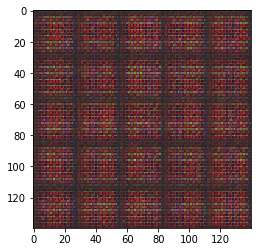

Epoch 1/1 Discriminator loss: 0.8124 Generator loss: 2.5240
Epoch 1/1 Discriminator loss: 0.6391 Generator loss: 2.0169
Epoch 1/1 Discriminator loss: 0.4142 Generator loss: 1.9636
Epoch 1/1 Discriminator loss: 0.3166 Generator loss: 2.9372
Epoch 1/1 Discriminator loss: 0.2691 Generator loss: 3.0827
Epoch 1/1 Discriminator loss: 0.2800 Generator loss: 2.7259
Epoch 1/1 Discriminator loss: 0.2579 Generator loss: 3.4499
Epoch 1/1 Discriminator loss: 0.1406 Generator loss: 3.7267
Epoch 1/1 Discriminator loss: 1.3459 Generator loss: 0.6425
Epoch 1/1 Discriminator loss: 1.3725 Generator loss: 9.2074
Epoch 1/1 Discriminator loss: 0.4733 Generator loss: 1.8617
Epoch 1/1 Discriminator loss: 0.1177 Generator loss: 4.5872
Epoch 1/1 Discriminator loss: 0.8277 Generator loss: 1.3502
Epoch 1/1 Discriminator loss: 0.2171 Generator loss: 8.9523
Epoch 1/1 Discriminator loss: 0.3239 Generator loss: 3.5464
Epoch 1/1 Discriminator loss: 2.0811 Generator loss: 0.3815
Epoch 1/1 Discriminator loss: 2.4499 Gen

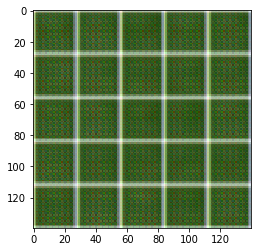

Epoch 1/1 Discriminator loss: 0.9689 Generator loss: 6.8048
Epoch 1/1 Discriminator loss: 1.4254 Generator loss: 1.5970
Epoch 1/1 Discriminator loss: 1.6526 Generator loss: 1.3414
Epoch 1/1 Discriminator loss: 1.3599 Generator loss: 3.9643
Epoch 1/1 Discriminator loss: 1.8715 Generator loss: 0.6020
Epoch 1/1 Discriminator loss: 1.2324 Generator loss: 6.5415
Epoch 1/1 Discriminator loss: 1.5944 Generator loss: 0.8846
Epoch 1/1 Discriminator loss: 0.9125 Generator loss: 3.2050
Epoch 1/1 Discriminator loss: 0.8914 Generator loss: 1.6605
Epoch 1/1 Discriminator loss: 1.3678 Generator loss: 1.3989
Epoch 1/1 Discriminator loss: 1.7390 Generator loss: 1.7252
Epoch 1/1 Discriminator loss: 3.0580 Generator loss: 0.3999
Epoch 1/1 Discriminator loss: 3.2611 Generator loss: 4.5681
Epoch 1/1 Discriminator loss: 3.6680 Generator loss: 0.1362
Epoch 1/1 Discriminator loss: 1.7782 Generator loss: 2.7195
Epoch 1/1 Discriminator loss: 1.9068 Generator loss: 1.0944
Epoch 1/1 Discriminator loss: 1.4524 Gen

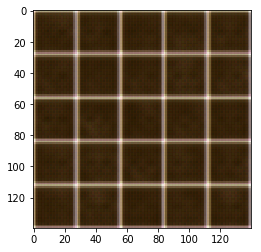

Epoch 1/1 Discriminator loss: 2.1196 Generator loss: 0.7386
Epoch 1/1 Discriminator loss: 1.2341 Generator loss: 2.0225
Epoch 1/1 Discriminator loss: 1.8119 Generator loss: 0.8495
Epoch 1/1 Discriminator loss: 1.6030 Generator loss: 2.8253
Epoch 1/1 Discriminator loss: 1.7529 Generator loss: 0.6302
Epoch 1/1 Discriminator loss: 1.3393 Generator loss: 1.7225
Epoch 1/1 Discriminator loss: 1.3545 Generator loss: 1.1789
Epoch 1/1 Discriminator loss: 1.2090 Generator loss: 1.9438
Epoch 1/1 Discriminator loss: 1.2461 Generator loss: 0.9931
Epoch 1/1 Discriminator loss: 1.3076 Generator loss: 1.7878
Epoch 1/1 Discriminator loss: 1.4280 Generator loss: 1.0870
Epoch 1/1 Discriminator loss: 1.4076 Generator loss: 2.4307
Epoch 1/1 Discriminator loss: 1.4278 Generator loss: 0.9847
Epoch 1/1 Discriminator loss: 1.1439 Generator loss: 2.4285
Epoch 1/1 Discriminator loss: 1.7940 Generator loss: 0.4784
Epoch 1/1 Discriminator loss: 1.6226 Generator loss: 4.0878
Epoch 1/1 Discriminator loss: 1.4743 Gen

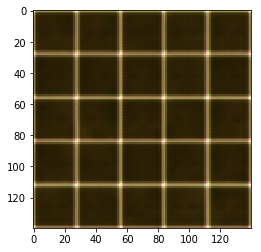

Epoch 1/1 Discriminator loss: 1.6532 Generator loss: 3.1526
Epoch 1/1 Discriminator loss: 1.9189 Generator loss: 0.4433
Epoch 1/1 Discriminator loss: 1.5294 Generator loss: 2.2155
Epoch 1/1 Discriminator loss: 1.6093 Generator loss: 0.7358
Epoch 1/1 Discriminator loss: 0.8473 Generator loss: 1.8885
Epoch 1/1 Discriminator loss: 1.2265 Generator loss: 1.1328
Epoch 1/1 Discriminator loss: 1.4633 Generator loss: 1.0972
Epoch 1/1 Discriminator loss: 1.5584 Generator loss: 1.3921
Epoch 1/1 Discriminator loss: 1.5806 Generator loss: 0.6928
Epoch 1/1 Discriminator loss: 1.3728 Generator loss: 1.4378
Epoch 1/1 Discriminator loss: 1.3193 Generator loss: 1.1556
Epoch 1/1 Discriminator loss: 1.3725 Generator loss: 1.2479
Epoch 1/1 Discriminator loss: 1.3418 Generator loss: 1.1072
Epoch 1/1 Discriminator loss: 1.7589 Generator loss: 0.5310
Epoch 1/1 Discriminator loss: 1.4913 Generator loss: 1.9206
Epoch 1/1 Discriminator loss: 1.8834 Generator loss: 0.6590
Epoch 1/1 Discriminator loss: 1.7407 Gen

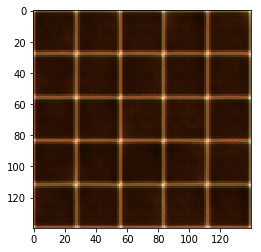

Epoch 1/1 Discriminator loss: 1.5336 Generator loss: 1.0839
Epoch 1/1 Discriminator loss: 1.3164 Generator loss: 1.2817
Epoch 1/1 Discriminator loss: 1.3801 Generator loss: 1.3004
Epoch 1/1 Discriminator loss: 1.8407 Generator loss: 0.4734
Epoch 1/1 Discriminator loss: 1.7742 Generator loss: 2.6494
Epoch 1/1 Discriminator loss: 2.1239 Generator loss: 0.3428
Epoch 1/1 Discriminator loss: 1.6328 Generator loss: 2.3797
Epoch 1/1 Discriminator loss: 1.6879 Generator loss: 0.6629
Epoch 1/1 Discriminator loss: 1.1005 Generator loss: 1.3293
Epoch 1/1 Discriminator loss: 1.2366 Generator loss: 1.0524
Epoch 1/1 Discriminator loss: 1.4360 Generator loss: 1.3278
Epoch 1/1 Discriminator loss: 1.1087 Generator loss: 1.1499
Epoch 1/1 Discriminator loss: 1.3976 Generator loss: 0.9164
Epoch 1/1 Discriminator loss: 1.1421 Generator loss: 1.9185
Epoch 1/1 Discriminator loss: 1.1776 Generator loss: 1.1178
Epoch 1/1 Discriminator loss: 1.1850 Generator loss: 1.2296
Epoch 1/1 Discriminator loss: 1.3445 Gen

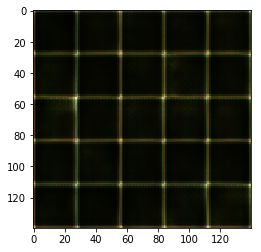

Epoch 1/1 Discriminator loss: 1.5666 Generator loss: 0.6891
Epoch 1/1 Discriminator loss: 1.1406 Generator loss: 1.3334
Epoch 1/1 Discriminator loss: 1.1858 Generator loss: 1.0899
Epoch 1/1 Discriminator loss: 1.0984 Generator loss: 1.2969
Epoch 1/1 Discriminator loss: 1.5534 Generator loss: 0.5105
Epoch 1/1 Discriminator loss: 1.7504 Generator loss: 1.7381
Epoch 1/1 Discriminator loss: 1.7519 Generator loss: 0.6672
Epoch 1/1 Discriminator loss: 1.4800 Generator loss: 0.9502
Epoch 1/1 Discriminator loss: 1.4506 Generator loss: 0.9622
Epoch 1/1 Discriminator loss: 1.5753 Generator loss: 0.9209
Epoch 1/1 Discriminator loss: 1.5643 Generator loss: 0.8322
Epoch 1/1 Discriminator loss: 1.6383 Generator loss: 1.0820
Epoch 1/1 Discriminator loss: 1.8625 Generator loss: 0.7957
Epoch 1/1 Discriminator loss: 1.9914 Generator loss: 0.7808
Epoch 1/1 Discriminator loss: 1.8213 Generator loss: 1.1007
Epoch 1/1 Discriminator loss: 1.5787 Generator loss: 1.0784
Epoch 1/1 Discriminator loss: 1.3682 Gen

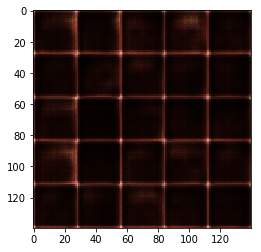

Epoch 1/1 Discriminator loss: 0.9063 Generator loss: 2.1529
Epoch 1/1 Discriminator loss: 0.9440 Generator loss: 1.3529
Epoch 1/1 Discriminator loss: 1.1896 Generator loss: 0.8078
Epoch 1/1 Discriminator loss: 1.0803 Generator loss: 1.4434
Epoch 1/1 Discriminator loss: 0.8706 Generator loss: 1.9546
Epoch 1/1 Discriminator loss: 1.1463 Generator loss: 0.7414
Epoch 1/1 Discriminator loss: 1.2491 Generator loss: 1.3778
Epoch 1/1 Discriminator loss: 1.0824 Generator loss: 1.2488
Epoch 1/1 Discriminator loss: 0.9400 Generator loss: 1.4211
Epoch 1/1 Discriminator loss: 0.9125 Generator loss: 1.4503
Epoch 1/1 Discriminator loss: 0.9697 Generator loss: 1.4487
Epoch 1/1 Discriminator loss: 1.1612 Generator loss: 0.8077
Epoch 1/1 Discriminator loss: 1.1030 Generator loss: 1.1834
Epoch 1/1 Discriminator loss: 0.9189 Generator loss: 1.2783
Epoch 1/1 Discriminator loss: 0.8710 Generator loss: 1.2271
Epoch 1/1 Discriminator loss: 0.8152 Generator loss: 1.6359
Epoch 1/1 Discriminator loss: 1.1780 Gen

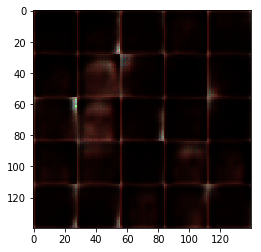

Epoch 1/1 Discriminator loss: 1.8631 Generator loss: 0.3679
Epoch 1/1 Discriminator loss: 1.4471 Generator loss: 1.4249
Epoch 1/1 Discriminator loss: 1.4697 Generator loss: 0.9529
Epoch 1/1 Discriminator loss: 1.4683 Generator loss: 0.7719
Epoch 1/1 Discriminator loss: 1.6335 Generator loss: 1.1950
Epoch 1/1 Discriminator loss: 1.3630 Generator loss: 0.8001
Epoch 1/1 Discriminator loss: 1.2356 Generator loss: 1.2192
Epoch 1/1 Discriminator loss: 1.3844 Generator loss: 0.8774
Epoch 1/1 Discriminator loss: 1.3027 Generator loss: 1.0249
Epoch 1/1 Discriminator loss: 1.3392 Generator loss: 1.6229
Epoch 1/1 Discriminator loss: 1.3534 Generator loss: 0.7783
Epoch 1/1 Discriminator loss: 1.6664 Generator loss: 0.6335
Epoch 1/1 Discriminator loss: 1.5333 Generator loss: 1.0977
Epoch 1/1 Discriminator loss: 1.6812 Generator loss: 0.7811
Epoch 1/1 Discriminator loss: 1.6339 Generator loss: 0.7048
Epoch 1/1 Discriminator loss: 1.2130 Generator loss: 1.2849
Epoch 1/1 Discriminator loss: 1.1897 Gen

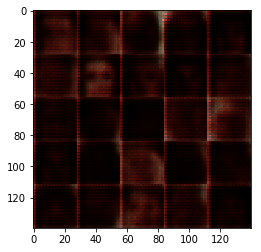

Epoch 1/1 Discriminator loss: 1.3128 Generator loss: 1.3142
Epoch 1/1 Discriminator loss: 1.4155 Generator loss: 0.9626
Epoch 1/1 Discriminator loss: 1.0855 Generator loss: 1.3992
Epoch 1/1 Discriminator loss: 1.3647 Generator loss: 0.6979
Epoch 1/1 Discriminator loss: 1.1737 Generator loss: 0.9885
Epoch 1/1 Discriminator loss: 1.3987 Generator loss: 0.8672
Epoch 1/1 Discriminator loss: 1.6362 Generator loss: 0.6670
Epoch 1/1 Discriminator loss: 1.4038 Generator loss: 0.7413
Epoch 1/1 Discriminator loss: 1.0789 Generator loss: 1.1381
Epoch 1/1 Discriminator loss: 1.1367 Generator loss: 1.0041
Epoch 1/1 Discriminator loss: 1.2700 Generator loss: 0.7890
Epoch 1/1 Discriminator loss: 1.4250 Generator loss: 0.7972
Epoch 1/1 Discriminator loss: 1.2528 Generator loss: 0.8810
Epoch 1/1 Discriminator loss: 1.2663 Generator loss: 1.0137
Epoch 1/1 Discriminator loss: 1.3626 Generator loss: 0.8556
Epoch 1/1 Discriminator loss: 1.7199 Generator loss: 0.5725
Epoch 1/1 Discriminator loss: 1.9309 Gen

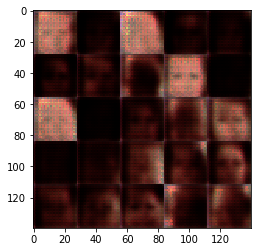

Epoch 1/1 Discriminator loss: 1.4352 Generator loss: 1.3611
Epoch 1/1 Discriminator loss: 1.3010 Generator loss: 1.0293
Epoch 1/1 Discriminator loss: 1.3202 Generator loss: 0.8676
Epoch 1/1 Discriminator loss: 1.1211 Generator loss: 0.9773
Epoch 1/1 Discriminator loss: 1.1124 Generator loss: 0.9738
Epoch 1/1 Discriminator loss: 1.0776 Generator loss: 0.9769
Epoch 1/1 Discriminator loss: 1.1164 Generator loss: 1.0656
Epoch 1/1 Discriminator loss: 1.4254 Generator loss: 0.8050
Epoch 1/1 Discriminator loss: 1.1635 Generator loss: 1.4029
Epoch 1/1 Discriminator loss: 1.6502 Generator loss: 0.4494
Epoch 1/1 Discriminator loss: 1.4401 Generator loss: 1.3311
Epoch 1/1 Discriminator loss: 1.5092 Generator loss: 1.2872
Epoch 1/1 Discriminator loss: 1.3927 Generator loss: 0.7223
Epoch 1/1 Discriminator loss: 1.1668 Generator loss: 1.3947
Epoch 1/1 Discriminator loss: 1.3778 Generator loss: 0.6932
Epoch 1/1 Discriminator loss: 1.2885 Generator loss: 1.2888
Epoch 1/1 Discriminator loss: 1.2233 Gen

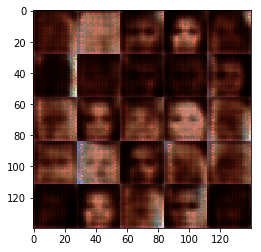

Epoch 1/1 Discriminator loss: 1.2832 Generator loss: 0.6990
Epoch 1/1 Discriminator loss: 1.3891 Generator loss: 0.8666
Epoch 1/1 Discriminator loss: 1.5914 Generator loss: 0.8642
Epoch 1/1 Discriminator loss: 1.4774 Generator loss: 0.6931
Epoch 1/1 Discriminator loss: 1.4822 Generator loss: 0.8759
Epoch 1/1 Discriminator loss: 1.3818 Generator loss: 0.8106
Epoch 1/1 Discriminator loss: 0.9493 Generator loss: 0.9922
Epoch 1/1 Discriminator loss: 1.0113 Generator loss: 1.0239
Epoch 1/1 Discriminator loss: 1.1281 Generator loss: 0.8623
Epoch 1/1 Discriminator loss: 1.2472 Generator loss: 0.8733
Epoch 1/1 Discriminator loss: 1.4216 Generator loss: 0.9726
Epoch 1/1 Discriminator loss: 1.8267 Generator loss: 0.6127
Epoch 1/1 Discriminator loss: 1.8848 Generator loss: 0.8145
Epoch 1/1 Discriminator loss: 2.0654 Generator loss: 0.5678
Epoch 1/1 Discriminator loss: 1.8885 Generator loss: 0.7795
Epoch 1/1 Discriminator loss: 1.7791 Generator loss: 0.9928
Epoch 1/1 Discriminator loss: 1.8525 Gen

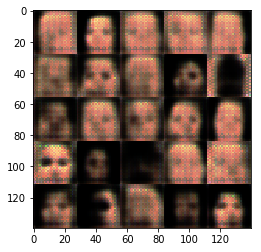

Epoch 1/1 Discriminator loss: 1.0755 Generator loss: 1.1937
Epoch 1/1 Discriminator loss: 1.2872 Generator loss: 0.9351
Epoch 1/1 Discriminator loss: 1.2449 Generator loss: 1.0240
Epoch 1/1 Discriminator loss: 1.5178 Generator loss: 0.9031
Epoch 1/1 Discriminator loss: 1.2350 Generator loss: 0.8526
Epoch 1/1 Discriminator loss: 1.5119 Generator loss: 0.9250
Epoch 1/1 Discriminator loss: 1.3835 Generator loss: 0.8657
Epoch 1/1 Discriminator loss: 1.5387 Generator loss: 0.7614
Epoch 1/1 Discriminator loss: 1.1039 Generator loss: 1.1872
Epoch 1/1 Discriminator loss: 1.2881 Generator loss: 0.9759
Epoch 1/1 Discriminator loss: 1.1907 Generator loss: 0.8442
Epoch 1/1 Discriminator loss: 0.9611 Generator loss: 1.0503
Epoch 1/1 Discriminator loss: 0.9855 Generator loss: 1.3572
Epoch 1/1 Discriminator loss: 0.9996 Generator loss: 1.0629
Epoch 1/1 Discriminator loss: 1.1407 Generator loss: 1.0118
Epoch 1/1 Discriminator loss: 1.3119 Generator loss: 1.2000
Epoch 1/1 Discriminator loss: 1.3901 Gen

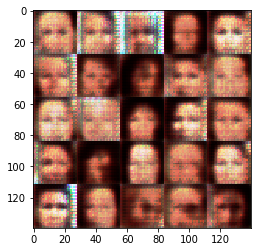

Epoch 1/1 Discriminator loss: 1.7000 Generator loss: 0.7098
Epoch 1/1 Discriminator loss: 1.9596 Generator loss: 0.5908
Epoch 1/1 Discriminator loss: 1.5978 Generator loss: 1.0125
Epoch 1/1 Discriminator loss: 1.4326 Generator loss: 0.8726
Epoch 1/1 Discriminator loss: 1.5462 Generator loss: 0.6627
Epoch 1/1 Discriminator loss: 1.1546 Generator loss: 1.4464
Epoch 1/1 Discriminator loss: 1.1397 Generator loss: 1.0505
Epoch 1/1 Discriminator loss: 1.3591 Generator loss: 0.9653
Epoch 1/1 Discriminator loss: 1.2787 Generator loss: 0.8944
Epoch 1/1 Discriminator loss: 1.4297 Generator loss: 0.8658
Epoch 1/1 Discriminator loss: 1.4891 Generator loss: 0.8281
Epoch 1/1 Discriminator loss: 1.3519 Generator loss: 1.0477
Epoch 1/1 Discriminator loss: 1.4052 Generator loss: 0.7665
Epoch 1/1 Discriminator loss: 1.4588 Generator loss: 1.3527
Epoch 1/1 Discriminator loss: 1.7312 Generator loss: 0.4971
Epoch 1/1 Discriminator loss: 1.3117 Generator loss: 1.2608
Epoch 1/1 Discriminator loss: 1.4545 Gen

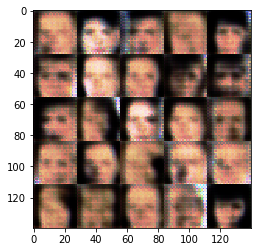

Epoch 1/1 Discriminator loss: 1.5718 Generator loss: 0.7631
Epoch 1/1 Discriminator loss: 1.4201 Generator loss: 0.7200
Epoch 1/1 Discriminator loss: 1.4438 Generator loss: 1.0330
Epoch 1/1 Discriminator loss: 1.7455 Generator loss: 0.4353
Epoch 1/1 Discriminator loss: 1.4285 Generator loss: 1.2105
Epoch 1/1 Discriminator loss: 1.4633 Generator loss: 0.7683
Epoch 1/1 Discriminator loss: 1.4343 Generator loss: 0.8003
Epoch 1/1 Discriminator loss: 1.3668 Generator loss: 0.9777
Epoch 1/1 Discriminator loss: 1.3751 Generator loss: 0.9790
Epoch 1/1 Discriminator loss: 1.6381 Generator loss: 0.6575
Epoch 1/1 Discriminator loss: 1.7428 Generator loss: 0.8007
Epoch 1/1 Discriminator loss: 1.9741 Generator loss: 0.5553
Epoch 1/1 Discriminator loss: 1.8023 Generator loss: 0.7621
Epoch 1/1 Discriminator loss: 1.9902 Generator loss: 0.7193
Epoch 1/1 Discriminator loss: 1.5577 Generator loss: 0.6724
Epoch 1/1 Discriminator loss: 1.4070 Generator loss: 0.9964
Epoch 1/1 Discriminator loss: 1.2619 Gen

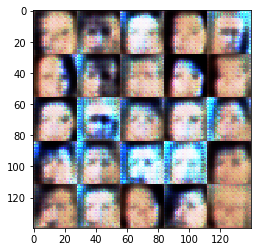

Epoch 1/1 Discriminator loss: 1.4037 Generator loss: 0.8233
Epoch 1/1 Discriminator loss: 1.2980 Generator loss: 1.0080
Epoch 1/1 Discriminator loss: 1.2962 Generator loss: 0.8453
Epoch 1/1 Discriminator loss: 1.0888 Generator loss: 0.9159
Epoch 1/1 Discriminator loss: 1.1666 Generator loss: 0.8609
Epoch 1/1 Discriminator loss: 1.2062 Generator loss: 0.8848
Epoch 1/1 Discriminator loss: 1.5805 Generator loss: 0.7852
Epoch 1/1 Discriminator loss: 1.3428 Generator loss: 0.9371
Epoch 1/1 Discriminator loss: 1.5790 Generator loss: 0.6478
Epoch 1/1 Discriminator loss: 1.4024 Generator loss: 1.1867
Epoch 1/1 Discriminator loss: 1.3540 Generator loss: 0.8392
Epoch 1/1 Discriminator loss: 1.5394 Generator loss: 0.6516
Epoch 1/1 Discriminator loss: 1.5172 Generator loss: 1.0940
Epoch 1/1 Discriminator loss: 1.5185 Generator loss: 0.7181
Epoch 1/1 Discriminator loss: 1.4371 Generator loss: 0.7974
Epoch 1/1 Discriminator loss: 1.5985 Generator loss: 0.8603
Epoch 1/1 Discriminator loss: 1.5051 Gen

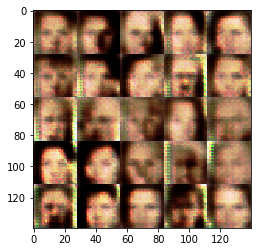

Epoch 1/1 Discriminator loss: 1.7271 Generator loss: 1.1432
Epoch 1/1 Discriminator loss: 1.6419 Generator loss: 0.6130
Epoch 1/1 Discriminator loss: 1.3415 Generator loss: 1.1594
Epoch 1/1 Discriminator loss: 1.2052 Generator loss: 0.9297
Epoch 1/1 Discriminator loss: 1.3954 Generator loss: 0.8141
Epoch 1/1 Discriminator loss: 1.3414 Generator loss: 0.8820
Epoch 1/1 Discriminator loss: 1.3252 Generator loss: 1.0262
Epoch 1/1 Discriminator loss: 1.3120 Generator loss: 0.8920
Epoch 1/1 Discriminator loss: 1.4576 Generator loss: 0.8367
Epoch 1/1 Discriminator loss: 1.3141 Generator loss: 1.0002
Epoch 1/1 Discriminator loss: 1.2390 Generator loss: 0.9022
Epoch 1/1 Discriminator loss: 1.5595 Generator loss: 0.6585
Epoch 1/1 Discriminator loss: 1.3983 Generator loss: 0.8066
Epoch 1/1 Discriminator loss: 1.2806 Generator loss: 1.0295
Epoch 1/1 Discriminator loss: 1.2430 Generator loss: 0.9315
Epoch 1/1 Discriminator loss: 1.2568 Generator loss: 0.9605
Epoch 1/1 Discriminator loss: 1.3412 Gen

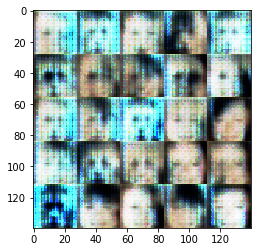

Epoch 1/1 Discriminator loss: 1.4655 Generator loss: 0.8450
Epoch 1/1 Discriminator loss: 1.3054 Generator loss: 0.9259
Epoch 1/1 Discriminator loss: 1.1818 Generator loss: 0.9945
Epoch 1/1 Discriminator loss: 1.2444 Generator loss: 0.8308
Epoch 1/1 Discriminator loss: 1.2230 Generator loss: 0.7836
Epoch 1/1 Discriminator loss: 1.2489 Generator loss: 0.8330
Epoch 1/1 Discriminator loss: 1.3141 Generator loss: 0.8661
Epoch 1/1 Discriminator loss: 1.4924 Generator loss: 0.9082
Epoch 1/1 Discriminator loss: 1.5816 Generator loss: 0.9212
Epoch 1/1 Discriminator loss: 1.5159 Generator loss: 0.8339
Epoch 1/1 Discriminator loss: 1.4801 Generator loss: 0.9722
Epoch 1/1 Discriminator loss: 1.5329 Generator loss: 0.8170
Epoch 1/1 Discriminator loss: 1.3591 Generator loss: 0.9948
Epoch 1/1 Discriminator loss: 1.4324 Generator loss: 0.5633
Epoch 1/1 Discriminator loss: 1.5461 Generator loss: 1.1647
Epoch 1/1 Discriminator loss: 1.6576 Generator loss: 0.7881
Epoch 1/1 Discriminator loss: 1.5709 Gen

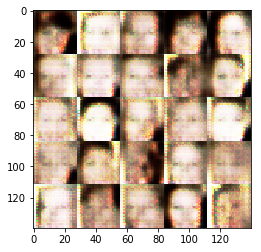

Epoch 1/1 Discriminator loss: 1.3709 Generator loss: 1.0585
Epoch 1/1 Discriminator loss: 1.3371 Generator loss: 0.8920
Epoch 1/1 Discriminator loss: 1.3238 Generator loss: 0.9700
Epoch 1/1 Discriminator loss: 1.3876 Generator loss: 0.8323
Epoch 1/1 Discriminator loss: 1.2452 Generator loss: 0.9628
Epoch 1/1 Discriminator loss: 1.3967 Generator loss: 0.8084
Epoch 1/1 Discriminator loss: 1.4299 Generator loss: 0.9921
Epoch 1/1 Discriminator loss: 1.2075 Generator loss: 1.1022
Epoch 1/1 Discriminator loss: 1.2401 Generator loss: 0.8269
Epoch 1/1 Discriminator loss: 1.1827 Generator loss: 1.0365
Epoch 1/1 Discriminator loss: 1.3111 Generator loss: 0.8277
Epoch 1/1 Discriminator loss: 1.3535 Generator loss: 0.8705
Epoch 1/1 Discriminator loss: 1.2385 Generator loss: 0.8920
Epoch 1/1 Discriminator loss: 1.3431 Generator loss: 0.8599
Epoch 1/1 Discriminator loss: 1.3784 Generator loss: 0.7510
Epoch 1/1 Discriminator loss: 1.4360 Generator loss: 0.8002
Epoch 1/1 Discriminator loss: 1.5726 Gen

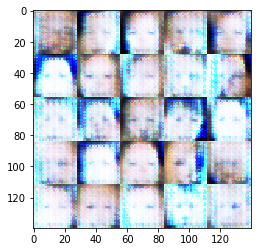

Epoch 1/1 Discriminator loss: 1.3643 Generator loss: 0.7354
Epoch 1/1 Discriminator loss: 1.3830 Generator loss: 0.8085
Epoch 1/1 Discriminator loss: 1.4603 Generator loss: 0.7464
Epoch 1/1 Discriminator loss: 1.3833 Generator loss: 0.8512
Epoch 1/1 Discriminator loss: 1.3212 Generator loss: 1.0022
Epoch 1/1 Discriminator loss: 1.1880 Generator loss: 1.0700
Epoch 1/1 Discriminator loss: 1.2061 Generator loss: 0.9115
Epoch 1/1 Discriminator loss: 1.4038 Generator loss: 0.8815
Epoch 1/1 Discriminator loss: 1.1278 Generator loss: 1.3119
Epoch 1/1 Discriminator loss: 1.3462 Generator loss: 0.6651
Epoch 1/1 Discriminator loss: 1.1864 Generator loss: 0.9698
Epoch 1/1 Discriminator loss: 1.2539 Generator loss: 1.0596
Epoch 1/1 Discriminator loss: 1.3923 Generator loss: 0.8510
Epoch 1/1 Discriminator loss: 1.3156 Generator loss: 0.8698
Epoch 1/1 Discriminator loss: 1.4391 Generator loss: 0.8881
Epoch 1/1 Discriminator loss: 1.6094 Generator loss: 0.5160
Epoch 1/1 Discriminator loss: 1.6775 Gen

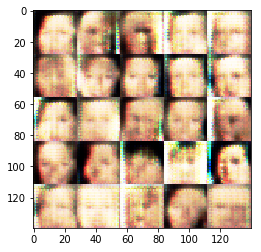

Epoch 1/1 Discriminator loss: 1.2360 Generator loss: 0.9684
Epoch 1/1 Discriminator loss: 1.3685 Generator loss: 0.8593
Epoch 1/1 Discriminator loss: 1.2568 Generator loss: 0.8043
Epoch 1/1 Discriminator loss: 1.3810 Generator loss: 0.9298
Epoch 1/1 Discriminator loss: 1.3455 Generator loss: 0.8511
Epoch 1/1 Discriminator loss: 1.3668 Generator loss: 0.7159
Epoch 1/1 Discriminator loss: 1.3316 Generator loss: 0.8567
Epoch 1/1 Discriminator loss: 1.2973 Generator loss: 0.9074
Epoch 1/1 Discriminator loss: 1.4238 Generator loss: 0.8893
Epoch 1/1 Discriminator loss: 1.5938 Generator loss: 0.7556
Epoch 1/1 Discriminator loss: 1.5443 Generator loss: 0.9424
Epoch 1/1 Discriminator loss: 1.4294 Generator loss: 0.7771
Epoch 1/1 Discriminator loss: 1.4738 Generator loss: 0.6485
Epoch 1/1 Discriminator loss: 1.4082 Generator loss: 0.9494
Epoch 1/1 Discriminator loss: 1.3829 Generator loss: 0.8232
Epoch 1/1 Discriminator loss: 1.3938 Generator loss: 0.7240
Epoch 1/1 Discriminator loss: 1.6065 Gen

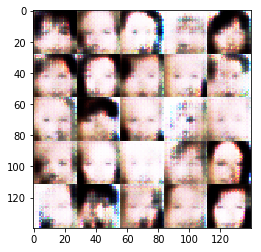

Epoch 1/1 Discriminator loss: 1.4372 Generator loss: 0.8547
Epoch 1/1 Discriminator loss: 1.2644 Generator loss: 0.8901
Epoch 1/1 Discriminator loss: 1.2069 Generator loss: 1.0265
Epoch 1/1 Discriminator loss: 1.1847 Generator loss: 1.1528
Epoch 1/1 Discriminator loss: 1.2410 Generator loss: 0.8529
Epoch 1/1 Discriminator loss: 1.3834 Generator loss: 0.7907
Epoch 1/1 Discriminator loss: 1.3067 Generator loss: 1.0866
Epoch 1/1 Discriminator loss: 1.3027 Generator loss: 0.8711
Epoch 1/1 Discriminator loss: 1.2791 Generator loss: 0.7056
Epoch 1/1 Discriminator loss: 1.4526 Generator loss: 0.7922
Epoch 1/1 Discriminator loss: 1.3308 Generator loss: 0.9223
Epoch 1/1 Discriminator loss: 1.2992 Generator loss: 0.8245
Epoch 1/1 Discriminator loss: 1.2825 Generator loss: 0.8696
Epoch 1/1 Discriminator loss: 1.2512 Generator loss: 1.0829
Epoch 1/1 Discriminator loss: 1.0921 Generator loss: 0.8269
Epoch 1/1 Discriminator loss: 1.2085 Generator loss: 0.8853
Epoch 1/1 Discriminator loss: 1.0925 Gen

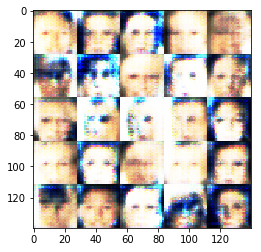

Epoch 1/1 Discriminator loss: 1.3815 Generator loss: 0.6958
Epoch 1/1 Discriminator loss: 1.4779 Generator loss: 0.8176
Epoch 1/1 Discriminator loss: 1.6486 Generator loss: 0.6570
Epoch 1/1 Discriminator loss: 1.7304 Generator loss: 0.6747
Epoch 1/1 Discriminator loss: 1.8702 Generator loss: 0.7279
Epoch 1/1 Discriminator loss: 1.5180 Generator loss: 0.7643
Epoch 1/1 Discriminator loss: 1.5184 Generator loss: 0.7577
Epoch 1/1 Discriminator loss: 1.6771 Generator loss: 0.7651
Epoch 1/1 Discriminator loss: 1.5289 Generator loss: 0.6057
Epoch 1/1 Discriminator loss: 1.5325 Generator loss: 0.8886
Epoch 1/1 Discriminator loss: 1.4365 Generator loss: 0.8107
Epoch 1/1 Discriminator loss: 1.2008 Generator loss: 0.8031
Epoch 1/1 Discriminator loss: 1.1910 Generator loss: 0.9333
Epoch 1/1 Discriminator loss: 1.2371 Generator loss: 0.9150
Epoch 1/1 Discriminator loss: 1.2561 Generator loss: 0.7954
Epoch 1/1 Discriminator loss: 1.3779 Generator loss: 0.7726
Epoch 1/1 Discriminator loss: 1.3899 Gen

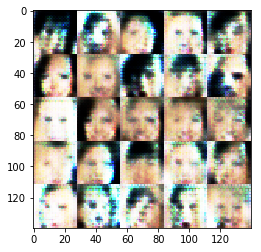

Epoch 1/1 Discriminator loss: 1.3725 Generator loss: 0.9198
Epoch 1/1 Discriminator loss: 1.3273 Generator loss: 0.7064
Epoch 1/1 Discriminator loss: 1.2321 Generator loss: 0.9296
Epoch 1/1 Discriminator loss: 1.2874 Generator loss: 0.8888
Epoch 1/1 Discriminator loss: 1.3006 Generator loss: 0.8708
Epoch 1/1 Discriminator loss: 1.3063 Generator loss: 0.7872
Epoch 1/1 Discriminator loss: 1.3314 Generator loss: 0.9154
Epoch 1/1 Discriminator loss: 1.3480 Generator loss: 0.7696
Epoch 1/1 Discriminator loss: 1.5648 Generator loss: 0.5734
Epoch 1/1 Discriminator loss: 1.4246 Generator loss: 0.7700
Epoch 1/1 Discriminator loss: 1.4920 Generator loss: 0.9281
Epoch 1/1 Discriminator loss: 1.4169 Generator loss: 0.7492
Epoch 1/1 Discriminator loss: 1.4578 Generator loss: 0.7250
Epoch 1/1 Discriminator loss: 1.2487 Generator loss: 1.3123
Epoch 1/1 Discriminator loss: 1.1653 Generator loss: 0.7381
Epoch 1/1 Discriminator loss: 1.2251 Generator loss: 0.8035
Epoch 1/1 Discriminator loss: 1.5076 Gen

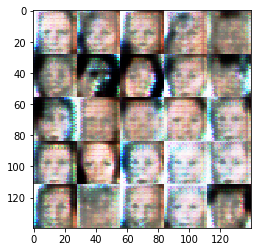

Epoch 1/1 Discriminator loss: 1.3398 Generator loss: 0.8204
Epoch 1/1 Discriminator loss: 1.3429 Generator loss: 0.8214
Epoch 1/1 Discriminator loss: 1.4985 Generator loss: 0.6119
Epoch 1/1 Discriminator loss: 1.6291 Generator loss: 0.8134
Epoch 1/1 Discriminator loss: 1.5424 Generator loss: 0.8261
Epoch 1/1 Discriminator loss: 1.5987 Generator loss: 0.6867
Epoch 1/1 Discriminator loss: 1.5973 Generator loss: 0.8607
Epoch 1/1 Discriminator loss: 1.4018 Generator loss: 0.8934
Epoch 1/1 Discriminator loss: 1.3020 Generator loss: 0.7282
Epoch 1/1 Discriminator loss: 1.3808 Generator loss: 0.7918
Epoch 1/1 Discriminator loss: 1.2924 Generator loss: 0.8483
Epoch 1/1 Discriminator loss: 1.3713 Generator loss: 0.8351
Epoch 1/1 Discriminator loss: 1.1620 Generator loss: 1.0425
Epoch 1/1 Discriminator loss: 1.3241 Generator loss: 0.9151
Epoch 1/1 Discriminator loss: 1.4801 Generator loss: 0.7953
Epoch 1/1 Discriminator loss: 1.2866 Generator loss: 0.8566
Epoch 1/1 Discriminator loss: 1.2570 Gen

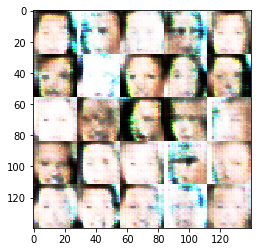

Epoch 1/1 Discriminator loss: 1.3941 Generator loss: 0.6442
Epoch 1/1 Discriminator loss: 1.4346 Generator loss: 0.8771
Epoch 1/1 Discriminator loss: 1.5126 Generator loss: 0.8014
Epoch 1/1 Discriminator loss: 1.4414 Generator loss: 0.7157
Epoch 1/1 Discriminator loss: 1.3706 Generator loss: 0.6219
Epoch 1/1 Discriminator loss: 1.3904 Generator loss: 0.8429
Epoch 1/1 Discriminator loss: 1.4214 Generator loss: 0.8469
Epoch 1/1 Discriminator loss: 1.2050 Generator loss: 1.1159
Epoch 1/1 Discriminator loss: 1.1741 Generator loss: 0.9633
Epoch 1/1 Discriminator loss: 1.3184 Generator loss: 0.8275
Epoch 1/1 Discriminator loss: 1.1457 Generator loss: 0.9017
Epoch 1/1 Discriminator loss: 1.3322 Generator loss: 0.8606
Epoch 1/1 Discriminator loss: 1.5360 Generator loss: 0.7598
Epoch 1/1 Discriminator loss: 1.4872 Generator loss: 0.7222
Epoch 1/1 Discriminator loss: 1.3629 Generator loss: 0.7601
Epoch 1/1 Discriminator loss: 1.5049 Generator loss: 0.7194
Epoch 1/1 Discriminator loss: 1.5685 Gen

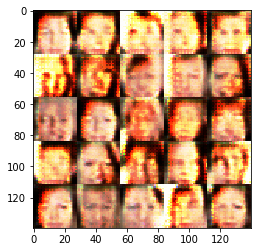

Epoch 1/1 Discriminator loss: 1.4302 Generator loss: 0.8097
Epoch 1/1 Discriminator loss: 1.5283 Generator loss: 0.7068
Epoch 1/1 Discriminator loss: 1.3892 Generator loss: 0.7966
Epoch 1/1 Discriminator loss: 1.3133 Generator loss: 0.8724
Epoch 1/1 Discriminator loss: 1.5127 Generator loss: 1.0014
Epoch 1/1 Discriminator loss: 1.4033 Generator loss: 0.7173
Epoch 1/1 Discriminator loss: 1.4474 Generator loss: 0.9387
Epoch 1/1 Discriminator loss: 1.3480 Generator loss: 0.9562
Epoch 1/1 Discriminator loss: 1.4480 Generator loss: 0.7603
Epoch 1/1 Discriminator loss: 1.2872 Generator loss: 0.8822
Epoch 1/1 Discriminator loss: 1.3306 Generator loss: 0.7284
Epoch 1/1 Discriminator loss: 1.4750 Generator loss: 0.7019
Epoch 1/1 Discriminator loss: 1.5460 Generator loss: 0.7050
Epoch 1/1 Discriminator loss: 1.5316 Generator loss: 0.6945
Epoch 1/1 Discriminator loss: 1.3866 Generator loss: 0.8971
Epoch 1/1 Discriminator loss: 1.2662 Generator loss: 0.9009
Epoch 1/1 Discriminator loss: 1.3651 Gen

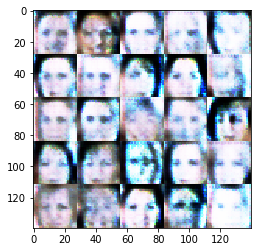

Epoch 1/1 Discriminator loss: 1.4020 Generator loss: 0.7555
Epoch 1/1 Discriminator loss: 1.4644 Generator loss: 0.7664
Epoch 1/1 Discriminator loss: 1.5036 Generator loss: 0.7147
Epoch 1/1 Discriminator loss: 1.4732 Generator loss: 0.7409
Epoch 1/1 Discriminator loss: 1.3923 Generator loss: 0.7807
Epoch 1/1 Discriminator loss: 1.4565 Generator loss: 0.7492
Epoch 1/1 Discriminator loss: 1.4647 Generator loss: 0.6711
Epoch 1/1 Discriminator loss: 1.4248 Generator loss: 0.6042
Epoch 1/1 Discriminator loss: 1.3841 Generator loss: 0.8952
Epoch 1/1 Discriminator loss: 1.5111 Generator loss: 0.8153
Epoch 1/1 Discriminator loss: 1.4852 Generator loss: 0.7962
Epoch 1/1 Discriminator loss: 1.3499 Generator loss: 0.9021
Epoch 1/1 Discriminator loss: 1.4533 Generator loss: 0.8393
Epoch 1/1 Discriminator loss: 1.3893 Generator loss: 0.7337
Epoch 1/1 Discriminator loss: 1.4765 Generator loss: 0.7300
Epoch 1/1 Discriminator loss: 1.3386 Generator loss: 0.7223
Epoch 1/1 Discriminator loss: 1.3735 Gen

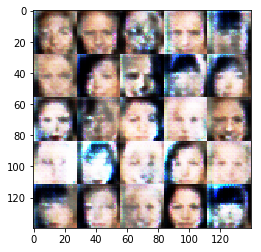

Epoch 1/1 Discriminator loss: 1.5999 Generator loss: 0.8250
Epoch 1/1 Discriminator loss: 1.5360 Generator loss: 0.6534
Epoch 1/1 Discriminator loss: 1.5321 Generator loss: 0.6722
Epoch 1/1 Discriminator loss: 1.3044 Generator loss: 0.8609
Epoch 1/1 Discriminator loss: 1.3489 Generator loss: 0.9837
Epoch 1/1 Discriminator loss: 1.1403 Generator loss: 0.9181
Epoch 1/1 Discriminator loss: 1.2068 Generator loss: 0.8699
Epoch 1/1 Discriminator loss: 1.1722 Generator loss: 0.9880
Epoch 1/1 Discriminator loss: 1.3136 Generator loss: 0.7448
Epoch 1/1 Discriminator loss: 1.2818 Generator loss: 0.8293
Epoch 1/1 Discriminator loss: 1.3757 Generator loss: 0.8364
Epoch 1/1 Discriminator loss: 1.4611 Generator loss: 0.6706
Epoch 1/1 Discriminator loss: 1.6382 Generator loss: 0.5800
Epoch 1/1 Discriminator loss: 1.5558 Generator loss: 0.7632
Epoch 1/1 Discriminator loss: 1.4497 Generator loss: 0.8904
Epoch 1/1 Discriminator loss: 1.2874 Generator loss: 0.8523
Epoch 1/1 Discriminator loss: 1.2100 Gen

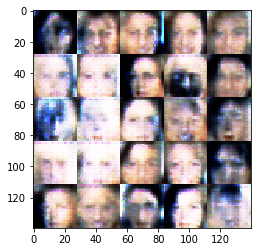

Epoch 1/1 Discriminator loss: 1.2766 Generator loss: 0.8168
Epoch 1/1 Discriminator loss: 1.4356 Generator loss: 0.7348
Epoch 1/1 Discriminator loss: 1.4374 Generator loss: 0.7742
Epoch 1/1 Discriminator loss: 1.4240 Generator loss: 0.7730
Epoch 1/1 Discriminator loss: 1.4916 Generator loss: 0.8103
Epoch 1/1 Discriminator loss: 1.3065 Generator loss: 0.7515
Epoch 1/1 Discriminator loss: 1.2865 Generator loss: 0.8241
Epoch 1/1 Discriminator loss: 1.2213 Generator loss: 0.7585
Epoch 1/1 Discriminator loss: 1.1953 Generator loss: 0.9888
Epoch 1/1 Discriminator loss: 1.3340 Generator loss: 0.8727
Epoch 1/1 Discriminator loss: 1.4884 Generator loss: 0.6285
Epoch 1/1 Discriminator loss: 1.5024 Generator loss: 0.8083
Epoch 1/1 Discriminator loss: 1.7051 Generator loss: 0.6318
Epoch 1/1 Discriminator loss: 1.4322 Generator loss: 0.7894
Epoch 1/1 Discriminator loss: 1.5640 Generator loss: 0.7456
Epoch 1/1 Discriminator loss: 1.4441 Generator loss: 0.8185
Epoch 1/1 Discriminator loss: 1.2540 Gen

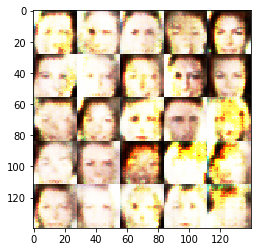

Epoch 1/1 Discriminator loss: 1.4841 Generator loss: 0.8154
Epoch 1/1 Discriminator loss: 1.4278 Generator loss: 0.7379
Epoch 1/1 Discriminator loss: 1.3443 Generator loss: 0.7112
Epoch 1/1 Discriminator loss: 1.5517 Generator loss: 0.8659
Epoch 1/1 Discriminator loss: 1.4026 Generator loss: 0.9322
Epoch 1/1 Discriminator loss: 1.6364 Generator loss: 0.7274
Epoch 1/1 Discriminator loss: 1.4380 Generator loss: 0.7700
Epoch 1/1 Discriminator loss: 1.3306 Generator loss: 0.9015
Epoch 1/1 Discriminator loss: 1.2839 Generator loss: 0.9465
Epoch 1/1 Discriminator loss: 1.3156 Generator loss: 0.8677
Epoch 1/1 Discriminator loss: 1.1771 Generator loss: 1.0389
Epoch 1/1 Discriminator loss: 1.1734 Generator loss: 0.9144
Epoch 1/1 Discriminator loss: 1.1488 Generator loss: 0.9113
Epoch 1/1 Discriminator loss: 1.2133 Generator loss: 0.7707
Epoch 1/1 Discriminator loss: 1.2334 Generator loss: 0.8432
Epoch 1/1 Discriminator loss: 1.5902 Generator loss: 0.7812
Epoch 1/1 Discriminator loss: 1.4326 Gen

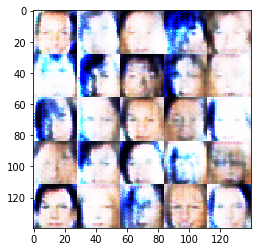

Epoch 1/1 Discriminator loss: 1.4566 Generator loss: 0.7205
Epoch 1/1 Discriminator loss: 1.4671 Generator loss: 0.6822
Epoch 1/1 Discriminator loss: 1.3746 Generator loss: 0.8375
Epoch 1/1 Discriminator loss: 1.3610 Generator loss: 0.7737
Epoch 1/1 Discriminator loss: 1.4572 Generator loss: 0.8087
Epoch 1/1 Discriminator loss: 1.4639 Generator loss: 0.9004
Epoch 1/1 Discriminator loss: 1.4159 Generator loss: 0.8613
Epoch 1/1 Discriminator loss: 1.4018 Generator loss: 0.8141
Epoch 1/1 Discriminator loss: 1.2532 Generator loss: 0.8803
Epoch 1/1 Discriminator loss: 1.1882 Generator loss: 0.9391
Epoch 1/1 Discriminator loss: 1.2347 Generator loss: 0.8472
Epoch 1/1 Discriminator loss: 1.3573 Generator loss: 0.7583
Epoch 1/1 Discriminator loss: 1.2674 Generator loss: 0.9929
Epoch 1/1 Discriminator loss: 1.2454 Generator loss: 0.8989
Epoch 1/1 Discriminator loss: 1.3202 Generator loss: 0.7267
Epoch 1/1 Discriminator loss: 1.4077 Generator loss: 0.8090
Epoch 1/1 Discriminator loss: 1.2050 Gen

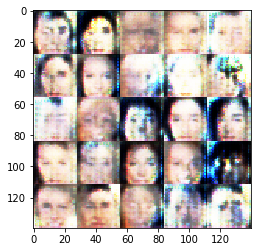

Epoch 1/1 Discriminator loss: 1.3874 Generator loss: 0.6801
Epoch 1/1 Discriminator loss: 1.4004 Generator loss: 0.7710
Epoch 1/1 Discriminator loss: 1.5828 Generator loss: 0.7230
Epoch 1/1 Discriminator loss: 1.5458 Generator loss: 0.7461
Epoch 1/1 Discriminator loss: 1.4599 Generator loss: 0.6734
Epoch 1/1 Discriminator loss: 1.5149 Generator loss: 0.6240
Epoch 1/1 Discriminator loss: 1.5605 Generator loss: 0.7112
Epoch 1/1 Discriminator loss: 1.4951 Generator loss: 0.7509
Epoch 1/1 Discriminator loss: 1.4737 Generator loss: 0.6428
Epoch 1/1 Discriminator loss: 1.5054 Generator loss: 0.6635
Epoch 1/1 Discriminator loss: 1.5733 Generator loss: 0.6972
Epoch 1/1 Discriminator loss: 1.5824 Generator loss: 0.7731
Epoch 1/1 Discriminator loss: 1.4771 Generator loss: 0.7229
Epoch 1/1 Discriminator loss: 1.5287 Generator loss: 0.8393
Epoch 1/1 Discriminator loss: 1.3538 Generator loss: 0.7825
Epoch 1/1 Discriminator loss: 1.3406 Generator loss: 0.7430
Epoch 1/1 Discriminator loss: 1.3753 Gen

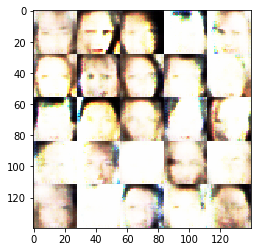

Epoch 1/1 Discriminator loss: 1.3728 Generator loss: 0.7569
Epoch 1/1 Discriminator loss: 1.3801 Generator loss: 0.7952
Epoch 1/1 Discriminator loss: 1.4380 Generator loss: 0.8067
Epoch 1/1 Discriminator loss: 1.4289 Generator loss: 0.8576
Epoch 1/1 Discriminator loss: 1.2566 Generator loss: 0.8816
Epoch 1/1 Discriminator loss: 1.3567 Generator loss: 0.7360
Epoch 1/1 Discriminator loss: 1.3164 Generator loss: 0.8232
Epoch 1/1 Discriminator loss: 1.3412 Generator loss: 0.7584
Epoch 1/1 Discriminator loss: 1.3870 Generator loss: 0.8424
Epoch 1/1 Discriminator loss: 1.3252 Generator loss: 0.8256
Epoch 1/1 Discriminator loss: 1.3694 Generator loss: 0.8323
Epoch 1/1 Discriminator loss: 1.2772 Generator loss: 0.7873
Epoch 1/1 Discriminator loss: 1.3733 Generator loss: 0.7575
Epoch 1/1 Discriminator loss: 1.3092 Generator loss: 0.6330
Epoch 1/1 Discriminator loss: 1.4390 Generator loss: 0.7208
Epoch 1/1 Discriminator loss: 1.4448 Generator loss: 0.7650
Epoch 1/1 Discriminator loss: 1.4306 Gen

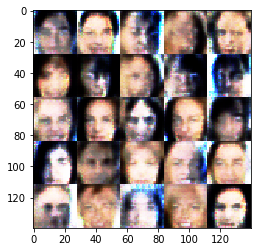

Epoch 1/1 Discriminator loss: 1.4596 Generator loss: 0.7540
Epoch 1/1 Discriminator loss: 1.3160 Generator loss: 0.6587
Epoch 1/1 Discriminator loss: 1.3914 Generator loss: 0.7817
Epoch 1/1 Discriminator loss: 1.4498 Generator loss: 0.8369
Epoch 1/1 Discriminator loss: 1.3514 Generator loss: 0.7218
Epoch 1/1 Discriminator loss: 1.3625 Generator loss: 0.6806
Epoch 1/1 Discriminator loss: 1.3772 Generator loss: 0.8133
Epoch 1/1 Discriminator loss: 1.4247 Generator loss: 0.7905
Epoch 1/1 Discriminator loss: 1.3856 Generator loss: 0.8115
Epoch 1/1 Discriminator loss: 1.4093 Generator loss: 0.7500
Epoch 1/1 Discriminator loss: 1.3941 Generator loss: 0.6915
Epoch 1/1 Discriminator loss: 1.3036 Generator loss: 0.7866
Epoch 1/1 Discriminator loss: 1.3195 Generator loss: 0.7568
Epoch 1/1 Discriminator loss: 1.3793 Generator loss: 0.6839
Epoch 1/1 Discriminator loss: 1.3231 Generator loss: 0.7762
Epoch 1/1 Discriminator loss: 1.3206 Generator loss: 0.8179
Epoch 1/1 Discriminator loss: 1.3187 Gen

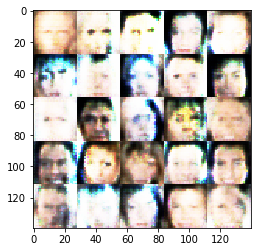

Epoch 1/1 Discriminator loss: 1.4332 Generator loss: 0.8314
Epoch 1/1 Discriminator loss: 1.3147 Generator loss: 0.7123
Epoch 1/1 Discriminator loss: 1.4075 Generator loss: 0.7512
Epoch 1/1 Discriminator loss: 1.5271 Generator loss: 0.7165
Epoch 1/1 Discriminator loss: 1.4808 Generator loss: 0.7322
Epoch 1/1 Discriminator loss: 1.4588 Generator loss: 0.8134
Epoch 1/1 Discriminator loss: 1.4193 Generator loss: 0.6997
Epoch 1/1 Discriminator loss: 1.4291 Generator loss: 0.6772
Epoch 1/1 Discriminator loss: 1.4562 Generator loss: 0.8232
Epoch 1/1 Discriminator loss: 1.3136 Generator loss: 0.8304
Epoch 1/1 Discriminator loss: 1.3416 Generator loss: 0.7623
Epoch 1/1 Discriminator loss: 1.3591 Generator loss: 0.8740
Epoch 1/1 Discriminator loss: 1.2481 Generator loss: 0.8926
Epoch 1/1 Discriminator loss: 1.3706 Generator loss: 0.7001
Epoch 1/1 Discriminator loss: 1.3567 Generator loss: 0.7925
Epoch 1/1 Discriminator loss: 1.3425 Generator loss: 0.8306
Epoch 1/1 Discriminator loss: 1.3422 Gen

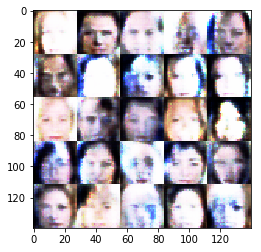

Epoch 1/1 Discriminator loss: 1.4003 Generator loss: 0.6681
Epoch 1/1 Discriminator loss: 1.3590 Generator loss: 0.7279
Epoch 1/1 Discriminator loss: 1.4403 Generator loss: 0.7413
Epoch 1/1 Discriminator loss: 1.4383 Generator loss: 0.7177
Epoch 1/1 Discriminator loss: 1.4839 Generator loss: 0.6723
Epoch 1/1 Discriminator loss: 1.3439 Generator loss: 0.7176
Epoch 1/1 Discriminator loss: 1.4190 Generator loss: 0.7356
Epoch 1/1 Discriminator loss: 1.4640 Generator loss: 0.6922
Epoch 1/1 Discriminator loss: 1.4140 Generator loss: 0.7439
Epoch 1/1 Discriminator loss: 1.3696 Generator loss: 0.8659
Epoch 1/1 Discriminator loss: 1.3595 Generator loss: 0.7564
Epoch 1/1 Discriminator loss: 1.4075 Generator loss: 0.7182
Epoch 1/1 Discriminator loss: 1.3349 Generator loss: 0.7956
Epoch 1/1 Discriminator loss: 1.3893 Generator loss: 0.8559
Epoch 1/1 Discriminator loss: 1.2709 Generator loss: 0.7620
Epoch 1/1 Discriminator loss: 1.4727 Generator loss: 0.7853
Epoch 1/1 Discriminator loss: 1.3992 Gen

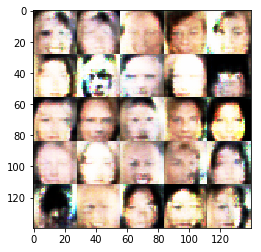

Epoch 1/1 Discriminator loss: 1.4793 Generator loss: 0.7430
Epoch 1/1 Discriminator loss: 1.3085 Generator loss: 0.7572
Epoch 1/1 Discriminator loss: 1.3758 Generator loss: 0.8829
Epoch 1/1 Discriminator loss: 1.3429 Generator loss: 0.8286
Epoch 1/1 Discriminator loss: 1.3457 Generator loss: 0.7839
Epoch 1/1 Discriminator loss: 1.4099 Generator loss: 0.8403
Epoch 1/1 Discriminator loss: 1.2591 Generator loss: 0.6995
Epoch 1/1 Discriminator loss: 1.3204 Generator loss: 0.6945
Epoch 1/1 Discriminator loss: 1.4198 Generator loss: 0.7272
Epoch 1/1 Discriminator loss: 1.5150 Generator loss: 0.7513
Epoch 1/1 Discriminator loss: 1.4202 Generator loss: 0.9143
Epoch 1/1 Discriminator loss: 1.5690 Generator loss: 0.6411
Epoch 1/1 Discriminator loss: 1.4407 Generator loss: 0.7553
Epoch 1/1 Discriminator loss: 1.4331 Generator loss: 0.6779
Epoch 1/1 Discriminator loss: 1.4116 Generator loss: 0.7850
Epoch 1/1 Discriminator loss: 1.4359 Generator loss: 0.8059
Epoch 1/1 Discriminator loss: 1.5249 Gen

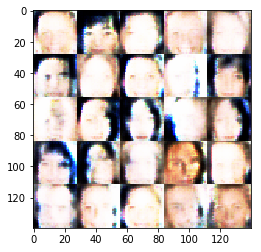

Epoch 1/1 Discriminator loss: 1.3706 Generator loss: 0.8115
Epoch 1/1 Discriminator loss: 1.3183 Generator loss: 0.8102
Epoch 1/1 Discriminator loss: 1.3231 Generator loss: 0.7663
Epoch 1/1 Discriminator loss: 1.2888 Generator loss: 0.7948
Epoch 1/1 Discriminator loss: 1.2517 Generator loss: 0.8209
Epoch 1/1 Discriminator loss: 1.4120 Generator loss: 0.7269
Epoch 1/1 Discriminator loss: 1.3446 Generator loss: 0.7058
Epoch 1/1 Discriminator loss: 1.5255 Generator loss: 0.7064
Epoch 1/1 Discriminator loss: 1.5324 Generator loss: 0.6769
Epoch 1/1 Discriminator loss: 1.3699 Generator loss: 0.6798
Epoch 1/1 Discriminator loss: 1.5380 Generator loss: 0.6650
Epoch 1/1 Discriminator loss: 1.4028 Generator loss: 0.6570
Epoch 1/1 Discriminator loss: 1.4156 Generator loss: 0.7851
Epoch 1/1 Discriminator loss: 1.3608 Generator loss: 0.7807
Epoch 1/1 Discriminator loss: 1.3152 Generator loss: 0.7574
Epoch 1/1 Discriminator loss: 1.4591 Generator loss: 0.7176
Epoch 1/1 Discriminator loss: 1.3537 Gen

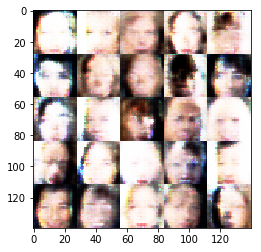

Epoch 1/1 Discriminator loss: 1.4025 Generator loss: 0.8150
Epoch 1/1 Discriminator loss: 1.3668 Generator loss: 0.7201
Epoch 1/1 Discriminator loss: 1.3432 Generator loss: 0.7214
Epoch 1/1 Discriminator loss: 1.3251 Generator loss: 0.8179
Epoch 1/1 Discriminator loss: 1.3443 Generator loss: 0.7583
Epoch 1/1 Discriminator loss: 1.3731 Generator loss: 0.7802
Epoch 1/1 Discriminator loss: 1.4192 Generator loss: 0.7515
Epoch 1/1 Discriminator loss: 1.3765 Generator loss: 0.8642
Epoch 1/1 Discriminator loss: 1.3613 Generator loss: 0.7846
Epoch 1/1 Discriminator loss: 1.3408 Generator loss: 0.8563
Epoch 1/1 Discriminator loss: 1.3305 Generator loss: 0.7518
Epoch 1/1 Discriminator loss: 1.3955 Generator loss: 0.7439
Epoch 1/1 Discriminator loss: 1.4271 Generator loss: 0.7159
Epoch 1/1 Discriminator loss: 1.5036 Generator loss: 0.6485
Epoch 1/1 Discriminator loss: 1.4742 Generator loss: 0.6624
Epoch 1/1 Discriminator loss: 1.4912 Generator loss: 0.7353
Epoch 1/1 Discriminator loss: 1.4483 Gen

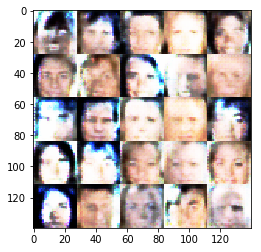

Epoch 1/1 Discriminator loss: 1.3275 Generator loss: 0.7479
Epoch 1/1 Discriminator loss: 1.3972 Generator loss: 0.8325
Epoch 1/1 Discriminator loss: 1.2924 Generator loss: 0.8223
Epoch 1/1 Discriminator loss: 1.3438 Generator loss: 0.6614
Epoch 1/1 Discriminator loss: 1.3922 Generator loss: 0.6855
Epoch 1/1 Discriminator loss: 1.3793 Generator loss: 0.6888
Epoch 1/1 Discriminator loss: 1.4192 Generator loss: 0.8264
Epoch 1/1 Discriminator loss: 1.3747 Generator loss: 0.8129
Epoch 1/1 Discriminator loss: 1.4275 Generator loss: 0.6900
Epoch 1/1 Discriminator loss: 1.4067 Generator loss: 0.7305
Epoch 1/1 Discriminator loss: 1.4182 Generator loss: 0.8700
Epoch 1/1 Discriminator loss: 1.4107 Generator loss: 0.8289
Epoch 1/1 Discriminator loss: 1.4894 Generator loss: 0.6995
Epoch 1/1 Discriminator loss: 1.3800 Generator loss: 0.7419
Epoch 1/1 Discriminator loss: 1.4243 Generator loss: 0.8048
Epoch 1/1 Discriminator loss: 1.4297 Generator loss: 0.6569
Epoch 1/1 Discriminator loss: 1.3785 Gen

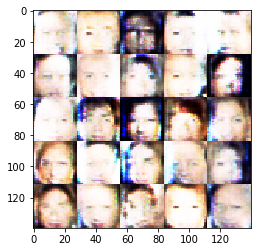

Epoch 1/1 Discriminator loss: 1.4275 Generator loss: 0.7790
Epoch 1/1 Discriminator loss: 1.3406 Generator loss: 0.7824
Epoch 1/1 Discriminator loss: 1.3854 Generator loss: 0.7431
Epoch 1/1 Discriminator loss: 1.4252 Generator loss: 0.7718
Epoch 1/1 Discriminator loss: 1.3613 Generator loss: 0.7452
Epoch 1/1 Discriminator loss: 1.3371 Generator loss: 0.7903
Epoch 1/1 Discriminator loss: 1.4673 Generator loss: 0.6543
Epoch 1/1 Discriminator loss: 1.4394 Generator loss: 0.6804
Epoch 1/1 Discriminator loss: 1.5571 Generator loss: 0.7842
Epoch 1/1 Discriminator loss: 1.5228 Generator loss: 0.6971
Epoch 1/1 Discriminator loss: 1.4957 Generator loss: 0.7065
Epoch 1/1 Discriminator loss: 1.4034 Generator loss: 0.7805
Epoch 1/1 Discriminator loss: 1.3253 Generator loss: 0.8246
Epoch 1/1 Discriminator loss: 1.3794 Generator loss: 0.8082
Epoch 1/1 Discriminator loss: 1.3016 Generator loss: 0.8347
Epoch 1/1 Discriminator loss: 1.3795 Generator loss: 0.8019
Epoch 1/1 Discriminator loss: 1.3572 Gen

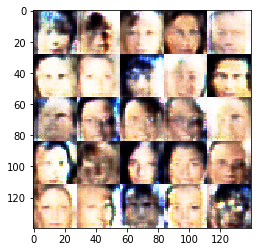

Epoch 1/1 Discriminator loss: 1.3831 Generator loss: 0.7331
Epoch 1/1 Discriminator loss: 1.3010 Generator loss: 0.7192
Epoch 1/1 Discriminator loss: 1.4417 Generator loss: 0.7481
Epoch 1/1 Discriminator loss: 1.3820 Generator loss: 0.7659
Epoch 1/1 Discriminator loss: 1.4127 Generator loss: 0.7086
Epoch 1/1 Discriminator loss: 1.3998 Generator loss: 0.7411
Epoch 1/1 Discriminator loss: 1.3344 Generator loss: 0.7547
Epoch 1/1 Discriminator loss: 1.3755 Generator loss: 0.7357
Epoch 1/1 Discriminator loss: 1.4674 Generator loss: 0.6939
Epoch 1/1 Discriminator loss: 1.3883 Generator loss: 0.7378
Epoch 1/1 Discriminator loss: 1.4472 Generator loss: 0.7472
Epoch 1/1 Discriminator loss: 1.4204 Generator loss: 0.8006
Epoch 1/1 Discriminator loss: 1.3530 Generator loss: 0.7614
Epoch 1/1 Discriminator loss: 1.4483 Generator loss: 0.7623
Epoch 1/1 Discriminator loss: 1.4570 Generator loss: 0.8293
Epoch 1/1 Discriminator loss: 1.4537 Generator loss: 0.7654
Epoch 1/1 Discriminator loss: 1.3427 Gen

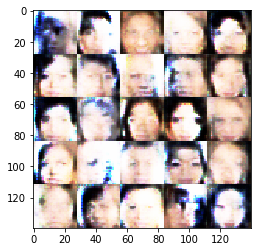

Epoch 1/1 Discriminator loss: 1.3564 Generator loss: 0.7318
Epoch 1/1 Discriminator loss: 1.3457 Generator loss: 0.7875
Epoch 1/1 Discriminator loss: 1.3764 Generator loss: 0.8263
Epoch 1/1 Discriminator loss: 1.4576 Generator loss: 0.6639
Epoch 1/1 Discriminator loss: 1.5145 Generator loss: 0.7232
Epoch 1/1 Discriminator loss: 1.5724 Generator loss: 0.7115
Epoch 1/1 Discriminator loss: 1.4688 Generator loss: 0.7099
Epoch 1/1 Discriminator loss: 1.4386 Generator loss: 0.6965
Epoch 1/1 Discriminator loss: 1.4065 Generator loss: 0.7456
Epoch 1/1 Discriminator loss: 1.4015 Generator loss: 0.6992
Epoch 1/1 Discriminator loss: 1.3793 Generator loss: 0.7233
Epoch 1/1 Discriminator loss: 1.2715 Generator loss: 0.7852
Epoch 1/1 Discriminator loss: 1.3460 Generator loss: 0.7804
Epoch 1/1 Discriminator loss: 1.2783 Generator loss: 0.8192
Epoch 1/1 Discriminator loss: 1.3952 Generator loss: 0.8032
Epoch 1/1 Discriminator loss: 1.3470 Generator loss: 0.7655
Epoch 1/1 Discriminator loss: 1.4881 Gen

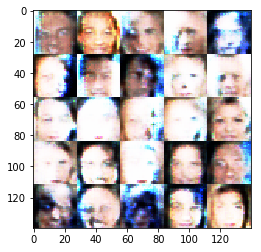

Epoch 1/1 Discriminator loss: 1.3668 Generator loss: 0.7346
Epoch 1/1 Discriminator loss: 1.5582 Generator loss: 0.7540
Epoch 1/1 Discriminator loss: 1.4242 Generator loss: 0.7393
Epoch 1/1 Discriminator loss: 1.4478 Generator loss: 0.6946
Epoch 1/1 Discriminator loss: 1.4744 Generator loss: 0.6945
Epoch 1/1 Discriminator loss: 1.5233 Generator loss: 0.6924
Epoch 1/1 Discriminator loss: 1.4666 Generator loss: 0.7547
Epoch 1/1 Discriminator loss: 1.4768 Generator loss: 0.7915
Epoch 1/1 Discriminator loss: 1.5053 Generator loss: 0.7746
Epoch 1/1 Discriminator loss: 1.3197 Generator loss: 0.7326
Epoch 1/1 Discriminator loss: 1.3265 Generator loss: 0.7849
Epoch 1/1 Discriminator loss: 1.3699 Generator loss: 0.7581
Epoch 1/1 Discriminator loss: 1.4107 Generator loss: 0.6576
Epoch 1/1 Discriminator loss: 1.3825 Generator loss: 0.7182
Epoch 1/1 Discriminator loss: 1.2882 Generator loss: 0.8577
Epoch 1/1 Discriminator loss: 1.3377 Generator loss: 0.8666
Epoch 1/1 Discriminator loss: 1.4694 Gen

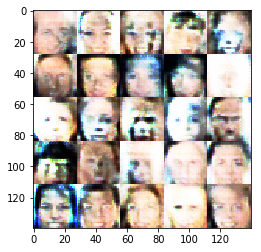

Epoch 1/1 Discriminator loss: 1.4174 Generator loss: 0.7464
Epoch 1/1 Discriminator loss: 1.3111 Generator loss: 0.8567
Epoch 1/1 Discriminator loss: 1.2968 Generator loss: 0.7938
Epoch 1/1 Discriminator loss: 1.3162 Generator loss: 0.7303
Epoch 1/1 Discriminator loss: 1.3036 Generator loss: 0.8287
Epoch 1/1 Discriminator loss: 1.3963 Generator loss: 0.8011
Epoch 1/1 Discriminator loss: 1.4338 Generator loss: 0.7274
Epoch 1/1 Discriminator loss: 1.2890 Generator loss: 0.7800
Epoch 1/1 Discriminator loss: 1.3440 Generator loss: 0.8272
Epoch 1/1 Discriminator loss: 1.3447 Generator loss: 0.8196
Epoch 1/1 Discriminator loss: 1.4414 Generator loss: 0.8170
Epoch 1/1 Discriminator loss: 1.4350 Generator loss: 0.7698
Epoch 1/1 Discriminator loss: 1.3172 Generator loss: 0.6919
Epoch 1/1 Discriminator loss: 1.4235 Generator loss: 0.7547
Epoch 1/1 Discriminator loss: 1.3887 Generator loss: 0.6987
Epoch 1/1 Discriminator loss: 1.4621 Generator loss: 0.7296
Epoch 1/1 Discriminator loss: 1.4229 Gen

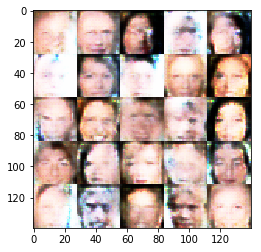

Epoch 1/1 Discriminator loss: 1.4663 Generator loss: 0.7673
Epoch 1/1 Discriminator loss: 1.3877 Generator loss: 0.7687
Epoch 1/1 Discriminator loss: 1.3593 Generator loss: 0.7248
Epoch 1/1 Discriminator loss: 1.3442 Generator loss: 0.8030
Epoch 1/1 Discriminator loss: 1.4018 Generator loss: 0.8452
Epoch 1/1 Discriminator loss: 1.3964 Generator loss: 0.7394
Epoch 1/1 Discriminator loss: 1.3387 Generator loss: 0.7495
Epoch 1/1 Discriminator loss: 1.4350 Generator loss: 0.6755
Epoch 1/1 Discriminator loss: 1.3454 Generator loss: 0.7526
Epoch 1/1 Discriminator loss: 1.4507 Generator loss: 0.7984
Epoch 1/1 Discriminator loss: 1.3484 Generator loss: 0.7902
Epoch 1/1 Discriminator loss: 1.4032 Generator loss: 0.6882
Epoch 1/1 Discriminator loss: 1.3692 Generator loss: 0.6919
Epoch 1/1 Discriminator loss: 1.3426 Generator loss: 0.7408
Epoch 1/1 Discriminator loss: 1.3957 Generator loss: 0.8194
Epoch 1/1 Discriminator loss: 1.3527 Generator loss: 0.7909
Epoch 1/1 Discriminator loss: 1.3872 Gen

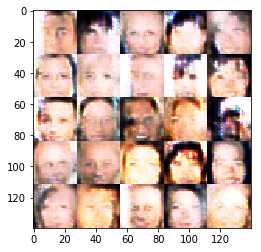

Epoch 1/1 Discriminator loss: 1.4355 Generator loss: 0.7908
Epoch 1/1 Discriminator loss: 1.4617 Generator loss: 0.7471
Epoch 1/1 Discriminator loss: 1.3924 Generator loss: 0.7477
Epoch 1/1 Discriminator loss: 1.4015 Generator loss: 0.6766
Epoch 1/1 Discriminator loss: 1.3017 Generator loss: 0.7386
Epoch 1/1 Discriminator loss: 1.2798 Generator loss: 0.7947
Epoch 1/1 Discriminator loss: 1.4061 Generator loss: 0.7618
Epoch 1/1 Discriminator loss: 1.3850 Generator loss: 0.6933
Epoch 1/1 Discriminator loss: 1.2909 Generator loss: 0.8617
Epoch 1/1 Discriminator loss: 1.4092 Generator loss: 0.7452
Epoch 1/1 Discriminator loss: 1.3637 Generator loss: 0.6766
Epoch 1/1 Discriminator loss: 1.3617 Generator loss: 0.7208
Epoch 1/1 Discriminator loss: 1.3726 Generator loss: 0.7862
Epoch 1/1 Discriminator loss: 1.4217 Generator loss: 0.7513
Epoch 1/1 Discriminator loss: 1.3366 Generator loss: 0.7505
Epoch 1/1 Discriminator loss: 1.3999 Generator loss: 0.7238
Epoch 1/1 Discriminator loss: 1.3264 Gen

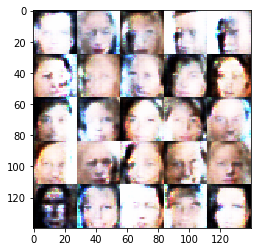

Epoch 1/1 Discriminator loss: 1.3991 Generator loss: 0.7420
Epoch 1/1 Discriminator loss: 1.4072 Generator loss: 0.8967
Epoch 1/1 Discriminator loss: 1.3441 Generator loss: 0.7948
Epoch 1/1 Discriminator loss: 1.3771 Generator loss: 0.7204
Epoch 1/1 Discriminator loss: 1.3194 Generator loss: 0.8172
Epoch 1/1 Discriminator loss: 1.3563 Generator loss: 0.7645
Epoch 1/1 Discriminator loss: 1.3854 Generator loss: 0.7179
Epoch 1/1 Discriminator loss: 1.3276 Generator loss: 0.7981
Epoch 1/1 Discriminator loss: 1.2957 Generator loss: 0.8029
Epoch 1/1 Discriminator loss: 1.4030 Generator loss: 0.7992
Epoch 1/1 Discriminator loss: 1.3815 Generator loss: 0.7527
Epoch 1/1 Discriminator loss: 1.4269 Generator loss: 0.6803
Epoch 1/1 Discriminator loss: 1.3203 Generator loss: 0.7213
Epoch 1/1 Discriminator loss: 1.3494 Generator loss: 0.7239
Epoch 1/1 Discriminator loss: 1.4951 Generator loss: 0.7207
Epoch 1/1 Discriminator loss: 1.4407 Generator loss: 0.7204
Epoch 1/1 Discriminator loss: 1.4602 Gen

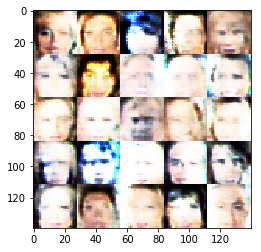

Epoch 1/1 Discriminator loss: 1.3352 Generator loss: 0.6864
Epoch 1/1 Discriminator loss: 1.4097 Generator loss: 0.7655
Epoch 1/1 Discriminator loss: 1.3818 Generator loss: 0.7482
Epoch 1/1 Discriminator loss: 1.3247 Generator loss: 0.7410
Epoch 1/1 Discriminator loss: 1.3492 Generator loss: 0.7649
Epoch 1/1 Discriminator loss: 1.3613 Generator loss: 0.7760
Epoch 1/1 Discriminator loss: 1.3764 Generator loss: 0.7357
Epoch 1/1 Discriminator loss: 1.4482 Generator loss: 0.7117
Epoch 1/1 Discriminator loss: 1.4042 Generator loss: 0.6833
Epoch 1/1 Discriminator loss: 1.4708 Generator loss: 0.7079
Epoch 1/1 Discriminator loss: 1.3502 Generator loss: 0.8724
Epoch 1/1 Discriminator loss: 1.3298 Generator loss: 0.7930
Epoch 1/1 Discriminator loss: 1.3740 Generator loss: 0.7980
Epoch 1/1 Discriminator loss: 1.4231 Generator loss: 0.7189
Epoch 1/1 Discriminator loss: 1.4347 Generator loss: 0.7397
Epoch 1/1 Discriminator loss: 1.3323 Generator loss: 0.7251
Epoch 1/1 Discriminator loss: 1.4307 Gen

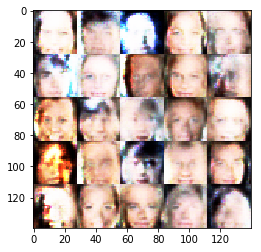

Epoch 1/1 Discriminator loss: 1.3202 Generator loss: 0.7973
Epoch 1/1 Discriminator loss: 1.4525 Generator loss: 0.6936
Epoch 1/1 Discriminator loss: 1.3760 Generator loss: 0.7596
Epoch 1/1 Discriminator loss: 1.3753 Generator loss: 0.7964
Epoch 1/1 Discriminator loss: 1.3249 Generator loss: 0.7631
Epoch 1/1 Discriminator loss: 1.3259 Generator loss: 0.7588
Epoch 1/1 Discriminator loss: 1.3737 Generator loss: 0.6993
Epoch 1/1 Discriminator loss: 1.3499 Generator loss: 0.7410
Epoch 1/1 Discriminator loss: 1.3475 Generator loss: 0.7350
Epoch 1/1 Discriminator loss: 1.3915 Generator loss: 0.7590
Epoch 1/1 Discriminator loss: 1.3788 Generator loss: 0.7360
Epoch 1/1 Discriminator loss: 1.4321 Generator loss: 0.6717
Epoch 1/1 Discriminator loss: 1.3583 Generator loss: 0.7149
Epoch 1/1 Discriminator loss: 1.3894 Generator loss: 0.7928
Epoch 1/1 Discriminator loss: 1.4304 Generator loss: 0.7490
Epoch 1/1 Discriminator loss: 1.4204 Generator loss: 0.7198
Epoch 1/1 Discriminator loss: 1.3158 Gen

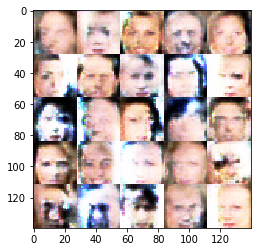

Epoch 1/1 Discriminator loss: 1.4025 Generator loss: 0.7276
Epoch 1/1 Discriminator loss: 1.3754 Generator loss: 0.7470
Epoch 1/1 Discriminator loss: 1.3263 Generator loss: 0.7358
Epoch 1/1 Discriminator loss: 1.3592 Generator loss: 0.7777
Epoch 1/1 Discriminator loss: 1.3586 Generator loss: 0.7686
Epoch 1/1 Discriminator loss: 1.3609 Generator loss: 0.7245
Epoch 1/1 Discriminator loss: 1.3845 Generator loss: 0.7600
Epoch 1/1 Discriminator loss: 1.3618 Generator loss: 0.7412
Epoch 1/1 Discriminator loss: 1.3344 Generator loss: 0.7928
Epoch 1/1 Discriminator loss: 1.3488 Generator loss: 0.7791
Epoch 1/1 Discriminator loss: 1.3536 Generator loss: 0.7415
Epoch 1/1 Discriminator loss: 1.3535 Generator loss: 0.7715
Epoch 1/1 Discriminator loss: 1.3750 Generator loss: 0.7051
Epoch 1/1 Discriminator loss: 1.3997 Generator loss: 0.7483
Epoch 1/1 Discriminator loss: 1.3936 Generator loss: 0.8272
Epoch 1/1 Discriminator loss: 1.3532 Generator loss: 0.7897
Epoch 1/1 Discriminator loss: 1.3788 Gen

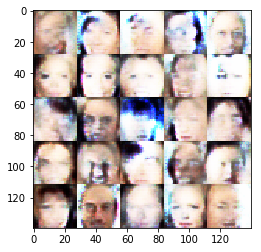

Epoch 1/1 Discriminator loss: 1.3231 Generator loss: 0.7731
Epoch 1/1 Discriminator loss: 1.3499 Generator loss: 0.7982
Epoch 1/1 Discriminator loss: 1.3644 Generator loss: 0.7451
Epoch 1/1 Discriminator loss: 1.3154 Generator loss: 0.7490
Epoch 1/1 Discriminator loss: 1.3407 Generator loss: 0.7229
Epoch 1/1 Discriminator loss: 1.3990 Generator loss: 0.7185
Epoch 1/1 Discriminator loss: 1.3160 Generator loss: 0.7146
Epoch 1/1 Discriminator loss: 1.3913 Generator loss: 0.6823
Epoch 1/1 Discriminator loss: 1.4024 Generator loss: 0.7503
Epoch 1/1 Discriminator loss: 1.4543 Generator loss: 0.7966
Epoch 1/1 Discriminator loss: 1.3389 Generator loss: 0.8129
Epoch 1/1 Discriminator loss: 1.3187 Generator loss: 0.7313
Epoch 1/1 Discriminator loss: 1.3719 Generator loss: 0.7299
Epoch 1/1 Discriminator loss: 1.4268 Generator loss: 0.7531
Epoch 1/1 Discriminator loss: 1.3366 Generator loss: 0.7266
Epoch 1/1 Discriminator loss: 1.3950 Generator loss: 0.7273
Epoch 1/1 Discriminator loss: 1.3132 Gen

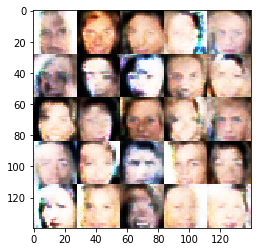

Epoch 1/1 Discriminator loss: 1.3629 Generator loss: 0.7308
Epoch 1/1 Discriminator loss: 1.3672 Generator loss: 0.7741
Epoch 1/1 Discriminator loss: 1.3297 Generator loss: 0.8338
Epoch 1/1 Discriminator loss: 1.3378 Generator loss: 0.7821
Epoch 1/1 Discriminator loss: 1.3732 Generator loss: 0.7326
Epoch 1/1 Discriminator loss: 1.3917 Generator loss: 0.6914
Epoch 1/1 Discriminator loss: 1.4522 Generator loss: 0.7519
Epoch 1/1 Discriminator loss: 1.4261 Generator loss: 0.7666
Epoch 1/1 Discriminator loss: 1.3849 Generator loss: 0.7680
Epoch 1/1 Discriminator loss: 1.3631 Generator loss: 0.7076
Epoch 1/1 Discriminator loss: 1.3626 Generator loss: 0.7057
Epoch 1/1 Discriminator loss: 1.3134 Generator loss: 0.7191
Epoch 1/1 Discriminator loss: 1.3164 Generator loss: 0.7306
Epoch 1/1 Discriminator loss: 1.3477 Generator loss: 0.7798
Epoch 1/1 Discriminator loss: 1.3018 Generator loss: 0.6954
Epoch 1/1 Discriminator loss: 1.3012 Generator loss: 0.7768
Epoch 1/1 Discriminator loss: 1.3209 Gen

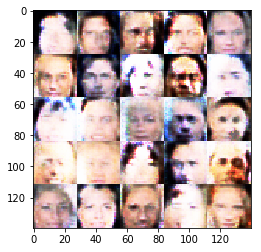

Epoch 1/1 Discriminator loss: 1.4283 Generator loss: 0.6639
Epoch 1/1 Discriminator loss: 1.4150 Generator loss: 0.7314
Epoch 1/1 Discriminator loss: 1.4414 Generator loss: 0.8120
Epoch 1/1 Discriminator loss: 1.4129 Generator loss: 0.7577
Epoch 1/1 Discriminator loss: 1.3764 Generator loss: 0.7272
Epoch 1/1 Discriminator loss: 1.3166 Generator loss: 0.7431
Epoch 1/1 Discriminator loss: 1.3248 Generator loss: 0.7669
Epoch 1/1 Discriminator loss: 1.2993 Generator loss: 0.8350
Epoch 1/1 Discriminator loss: 1.4042 Generator loss: 0.7892
Epoch 1/1 Discriminator loss: 1.3968 Generator loss: 0.7897
Epoch 1/1 Discriminator loss: 1.3567 Generator loss: 0.7392
Epoch 1/1 Discriminator loss: 1.4239 Generator loss: 0.7277
Epoch 1/1 Discriminator loss: 1.3333 Generator loss: 0.7281
Epoch 1/1 Discriminator loss: 1.3710 Generator loss: 0.7361
Epoch 1/1 Discriminator loss: 1.3183 Generator loss: 0.7556
Epoch 1/1 Discriminator loss: 1.3429 Generator loss: 0.8259
Epoch 1/1 Discriminator loss: 1.3868 Gen

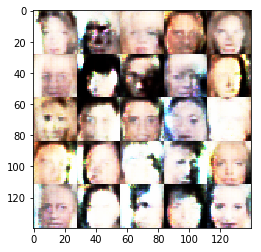

Epoch 1/1 Discriminator loss: 1.4153 Generator loss: 0.6916
Epoch 1/1 Discriminator loss: 1.5249 Generator loss: 0.7197
Epoch 1/1 Discriminator loss: 1.2883 Generator loss: 0.7305
Epoch 1/1 Discriminator loss: 1.3626 Generator loss: 0.7464
Epoch 1/1 Discriminator loss: 1.3823 Generator loss: 0.8125
Epoch 1/1 Discriminator loss: 1.3579 Generator loss: 0.8402
Epoch 1/1 Discriminator loss: 1.3702 Generator loss: 0.7602
Epoch 1/1 Discriminator loss: 1.3799 Generator loss: 0.7622
Epoch 1/1 Discriminator loss: 1.3360 Generator loss: 0.7839
Epoch 1/1 Discriminator loss: 1.4146 Generator loss: 0.8024
Epoch 1/1 Discriminator loss: 1.3807 Generator loss: 0.7277
Epoch 1/1 Discriminator loss: 1.3556 Generator loss: 0.7405
Epoch 1/1 Discriminator loss: 1.3479 Generator loss: 0.7421
Epoch 1/1 Discriminator loss: 1.3505 Generator loss: 0.6924
Epoch 1/1 Discriminator loss: 1.3759 Generator loss: 0.7416
Epoch 1/1 Discriminator loss: 1.3900 Generator loss: 0.7989
Epoch 1/1 Discriminator loss: 1.3763 Gen

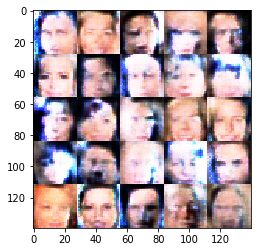

Epoch 1/1 Discriminator loss: 1.4686 Generator loss: 0.7697
Epoch 1/1 Discriminator loss: 1.4276 Generator loss: 0.7531
Epoch 1/1 Discriminator loss: 1.4559 Generator loss: 0.7116
Epoch 1/1 Discriminator loss: 1.3867 Generator loss: 0.7377
Epoch 1/1 Discriminator loss: 1.4235 Generator loss: 0.7594
Epoch 1/1 Discriminator loss: 1.4018 Generator loss: 0.7780
Epoch 1/1 Discriminator loss: 1.3536 Generator loss: 0.7649
Epoch 1/1 Discriminator loss: 1.3749 Generator loss: 0.7311
Epoch 1/1 Discriminator loss: 1.3664 Generator loss: 0.7547
Epoch 1/1 Discriminator loss: 1.2855 Generator loss: 0.7545
Epoch 1/1 Discriminator loss: 1.3007 Generator loss: 0.7824
Epoch 1/1 Discriminator loss: 1.3466 Generator loss: 0.7895
Epoch 1/1 Discriminator loss: 1.3900 Generator loss: 0.7195
Epoch 1/1 Discriminator loss: 1.4339 Generator loss: 0.7629
Epoch 1/1 Discriminator loss: 1.2866 Generator loss: 0.8103
Epoch 1/1 Discriminator loss: 1.3692 Generator loss: 0.7520
Epoch 1/1 Discriminator loss: 1.3397 Gen

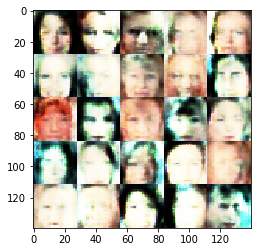

Epoch 1/1 Discriminator loss: 1.2642 Generator loss: 0.7703
Epoch 1/1 Discriminator loss: 1.3299 Generator loss: 0.7810
Epoch 1/1 Discriminator loss: 1.3387 Generator loss: 0.7714
Epoch 1/1 Discriminator loss: 1.4556 Generator loss: 0.6897
Epoch 1/1 Discriminator loss: 1.4276 Generator loss: 0.7753
Epoch 1/1 Discriminator loss: 1.4083 Generator loss: 0.7147
Epoch 1/1 Discriminator loss: 1.3716 Generator loss: 0.7141
Epoch 1/1 Discriminator loss: 1.3546 Generator loss: 0.7211
Epoch 1/1 Discriminator loss: 1.4117 Generator loss: 0.7115
Epoch 1/1 Discriminator loss: 1.3943 Generator loss: 0.7678
Epoch 1/1 Discriminator loss: 1.3939 Generator loss: 0.6969
Epoch 1/1 Discriminator loss: 1.4040 Generator loss: 0.7677
Epoch 1/1 Discriminator loss: 1.3781 Generator loss: 0.7799
Epoch 1/1 Discriminator loss: 1.4186 Generator loss: 0.7819
Epoch 1/1 Discriminator loss: 1.3732 Generator loss: 0.7045
Epoch 1/1 Discriminator loss: 1.3342 Generator loss: 0.7263
Epoch 1/1 Discriminator loss: 1.4526 Gen

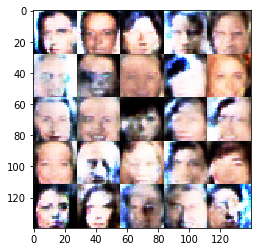

Epoch 1/1 Discriminator loss: 1.3774 Generator loss: 0.7676
Epoch 1/1 Discriminator loss: 1.3715 Generator loss: 0.7530
Epoch 1/1 Discriminator loss: 1.4534 Generator loss: 0.7702
Epoch 1/1 Discriminator loss: 1.3280 Generator loss: 0.7628
Epoch 1/1 Discriminator loss: 1.4749 Generator loss: 0.7481
Epoch 1/1 Discriminator loss: 1.4485 Generator loss: 0.7463
Epoch 1/1 Discriminator loss: 1.4036 Generator loss: 0.6856
Epoch 1/1 Discriminator loss: 1.3857 Generator loss: 0.7047
Epoch 1/1 Discriminator loss: 1.3771 Generator loss: 0.7812
Epoch 1/1 Discriminator loss: 1.3848 Generator loss: 0.7382
Epoch 1/1 Discriminator loss: 1.3810 Generator loss: 0.7842
Epoch 1/1 Discriminator loss: 1.3592 Generator loss: 0.7569
Epoch 1/1 Discriminator loss: 1.3959 Generator loss: 0.8033


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.